# Project 2 - Housing regression challenge

## Import libraries and data

In [335]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [336]:
housing = pd.read_csv('./Data/train.csv', index_col='Id')

## EDA on training set

### Initial look at data

In [337]:
housing.shape

(2051, 80)

In [338]:
housing.columns

Index(['PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish'

In [339]:
# Column definitions: https://www.kaggle.com/c/dsi-us-4-project-2-regression-challenge/data

### Null values

In [340]:
# check columns for null values
housing.isnull().sum()[housing.isnull().sum() !=0]

Lot Frontage       330
Alley             1911
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Qual           55
Bsmt Cond           55
Bsmt Exposure       58
BsmtFin Type 1      55
BsmtFin SF 1         1
BsmtFin Type 2      56
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1000
Garage Type        113
Garage Yr Blt      114
Garage Finish      114
Garage Cars          1
Garage Area          1
Garage Qual        114
Garage Cond        114
Pool QC           2042
Fence             1651
Misc Feature      1986
dtype: int64

In [341]:
# check how many rows have null values
housing.shape[0] - housing.dropna().shape[0]

2051

In [342]:
# check whether Misc Features should be filled with NA - check that Misc Val is zero
print(housing['Misc Feature'].unique())
sum(housing[housing['Misc Feature'].isnull()]['Misc Val']!=0)

[nan 'Shed' 'TenC' 'Gar2' 'Othr' 'Elev']


0

In [343]:
# fill empty Misc Features with NA
housing.loc[housing['Misc Feature'].isnull(),'Misc Feature']='NA'

In [344]:
# check whether blanks should be filled with NA for high null count columns
print('Fence qual: ',housing['Fence'].unique())
print('Pool qual: ',housing['Pool QC'].unique())
print('Alley type: ',housing['Alley'].unique())
print('Fireplace qual: ',housing['Fireplace Qu'].unique())

Fence qual:  [nan 'MnPrv' 'GdPrv' 'GdWo' 'MnWw']
Pool qual:  [nan 'Fa' 'Gd' 'Ex' 'TA']
Alley type:  [nan 'Pave' 'Grvl']
Fireplace qual:  [nan 'TA' 'Gd' 'Po' 'Ex' 'Fa']


In [345]:
# fill blanks with NA for these features
housing.loc[housing['Fence'].isnull(),'Fence']='NA'
housing.loc[housing['Pool QC'].isnull(),'Pool QC']='NA'
housing.loc[housing['Alley'].isnull(),'Alley']='NA'
housing.loc[housing['Fireplace Qu'].isnull(),'Fireplace Qu']='NA'

In [346]:
# check for blanks again
housing.isnull().sum()[housing.isnull().sum() !=0]

Lot Frontage      330
Mas Vnr Type       22
Mas Vnr Area       22
Bsmt Qual          55
Bsmt Cond          55
Bsmt Exposure      58
BsmtFin Type 1     55
BsmtFin SF 1        1
BsmtFin Type 2     56
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Bsmt Full Bath      2
Bsmt Half Bath      2
Garage Type       113
Garage Yr Blt     114
Garage Finish     114
Garage Cars         1
Garage Area         1
Garage Qual       114
Garage Cond       114
dtype: int64

In [347]:
# look at garages with null condition
garages = housing.loc[housing['Garage Cond'].isnull(),'Garage Type':'Garage Cond']

In [348]:
# make sure this subset corresponds to all null values found above
garages.isnull().sum()

Garage Type      113
Garage Yr Blt    114
Garage Finish    114
Garage Cars        1
Garage Area        1
Garage Qual      114
Garage Cond      114
dtype: int64

In [349]:
# look at values that aren't null
print('Type: ',garages['Garage Type'].unique())
print('Cars: ',garages['Garage Cars'].unique())
print('Area: ',garages['Garage Area'].unique())

Type:  [nan 'Detchd']
Cars:  [ 0. nan]
Area:  [ 0. nan]


In [350]:
garages[garages['Garage Type']=='Detchd']

Garage Type  Garage Yr Blt Garage Finish  Garage Cars  Garage Area  \
Id                                                                        
2237      Detchd            NaN           NaN          NaN          NaN   

     Garage Qual Garage Cond  
Id                            
2237         NaN         NaN

In [351]:
# fill in Garage data, assuming type in row above was filled in in error

housing.loc[housing['Garage Cond'].isnull(),'Garage Type'] = 'NA'
housing.loc[housing['Garage Cond'].isnull(),'Garage Yr Blt'] = 'NA'
housing.loc[housing['Garage Cond'].isnull(),'Garage Finish'] = 'NA'
housing.loc[housing['Garage Cond'].isnull(),'Garage Cars'] = 0
housing.loc[housing['Garage Cond'].isnull(),'Garage Area'] = 0
housing.loc[housing['Garage Cond'].isnull(),'Garage Qual'] = 'NA'
housing.loc[housing['Garage Cond'].isnull(),'Garage Cond'] = 'NA'

In [352]:
housing.isnull().sum()[housing.isnull().sum() != 0]

Lot Frontage      330
Mas Vnr Type       22
Mas Vnr Area       22
Bsmt Qual          55
Bsmt Cond          55
Bsmt Exposure      58
BsmtFin Type 1     55
BsmtFin SF 1        1
BsmtFin Type 2     56
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Bsmt Full Bath      2
Bsmt Half Bath      2
dtype: int64

In [353]:
# look at basements with null exposure
b_filter = [col for col in housing.columns if col.find('Bsmt')>=0]
basements = housing.loc[housing['Bsmt Exposure'].isnull(),b_filter]
basements.head()

Bsmt Qual Bsmt Cond Bsmt Exposure BsmtFin Type 1  BsmtFin SF 1  \
Id                                                                    
807        NaN       NaN           NaN            NaN           0.0   
811        NaN       NaN           NaN            NaN           0.0   
781        NaN       NaN           NaN            NaN           0.0   
888        NaN       NaN           NaN            NaN           0.0   
1554       NaN       NaN           NaN            NaN           0.0   

     BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  Bsmt Full Bath  \
Id                                                                              
807             NaN           0.0          0.0            0.0             0.0   
811             NaN           0.0          0.0            0.0             0.0   
781             NaN           0.0          0.0            0.0             0.0   
888             NaN           0.0          0.0            0.0             0.0   
1554            NaN           0.0          0.0            0.0             0.0   

      Bsmt Half Bath  
Id                    
807              0.0  
811              0.0  
781              0.0  
888              0.0  
1554             0.0

In [354]:
# fill NaN values in numeric columns with 0
housing.loc[housing['Bsmt Exposure'].isnull(),'BsmtFin SF 1'] = 0
housing.loc[housing['Bsmt Exposure'].isnull(),'BsmtFin SF 2'] = 0
housing.loc[housing['Bsmt Exposure'].isnull(),'Bsmt Unf SF'] = 0
housing.loc[housing['Bsmt Exposure'].isnull(),'Total Bsmt SF'] = 0
housing.loc[housing['Bsmt Exposure'].isnull(),'Bsmt Full Bath'] = 0
housing.loc[housing['Bsmt Exposure'].isnull(),'Bsmt Half Bath'] = 0

In [355]:
# just look at rows that have data in them
basements.dropna(how = 'all')
basements[basements.sum(axis=1)!=0]

Bsmt Qual Bsmt Cond Bsmt Exposure BsmtFin Type 1  BsmtFin SF 1  \
Id                                                                    
1797        Gd        TA           NaN            Unf           0.0   
67          Gd        TA           NaN            Unf           0.0   
2780        Gd        TA           NaN            Unf           0.0   

     BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  Bsmt Full Bath  \
Id                                                                              
1797            Unf           0.0        725.0          725.0             0.0   
67              Unf           0.0       1595.0         1595.0             0.0   
2780            Unf           0.0        936.0          936.0             0.0   

      Bsmt Half Bath  
Id                    
1797             0.0  
67               0.0  
2780             0.0

In [356]:
# fill in exposure for these as 'No'
housing.loc[[1797,67,2780],'Bsmt Exposure'] = 'No'

In [357]:
# fill NaN values in string columns with 'NA'
housing.loc[housing['Bsmt Exposure'].isnull(),'Bsmt Qual'] = 'NA'
housing.loc[housing['Bsmt Exposure'].isnull(),'Bsmt Cond'] = 'NA'
housing.loc[housing['Bsmt Exposure'].isnull(),'BsmtFin Type 1'] = 'NA'
housing.loc[housing['Bsmt Exposure'].isnull(),'BsmtFin Type 2'] = 'NA'
housing.loc[housing['Bsmt Exposure'].isnull(),'Bsmt Exposure'] = 'NA'

In [358]:
# check nulls again
housing.isnull().sum()[housing.isnull().sum()!=0]

Lot Frontage      330
Mas Vnr Type       22
Mas Vnr Area       22
BsmtFin Type 2      1
dtype: int64

In [359]:
# look at basement data with null value
housing.loc[housing['BsmtFin Type 2'].isnull(), b_filter]

Bsmt Qual Bsmt Cond Bsmt Exposure BsmtFin Type 1  BsmtFin SF 1  \
Id                                                                   
445        Gd        TA            No            GLQ        1124.0   

    BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  Bsmt Full Bath  \
Id                                                                             
445            NaN         479.0       1603.0         3206.0             1.0   

     Bsmt Half Bath  
Id                   
445             0.0

In [360]:
# assume same quality as other basement
housing.loc[445,'BsmtFin Type 2'] = 'GLQ'

In [361]:
# look at veneer
housing['Mas Vnr Type'].unique()

array(['BrkFace', 'None', nan, 'Stone', 'BrkCmn'], dtype=object)

In [362]:
sum(housing['Mas Vnr Type'].isnull() != housing['Mas Vnr Area'].isnull())

0

In [363]:
housing.loc[(housing['Mas Vnr Type']=='None') & (housing['Mas Vnr Area'] == 0)].shape[0]

1213

In [364]:
# since both are missing, assume no veneer
housing.loc[housing['Mas Vnr Type'].isnull(), 'Mas Vnr Type'] = 'None'
housing.loc[housing['Mas Vnr Area'].isnull(), 'Mas Vnr Area'] = 0

In [365]:
# look at Lot Frontage
print(housing[housing['Lot Frontage'].isnull()]['Lot Config'].unique())
housing[housing['Lot Frontage']==0]

['CulDSac' 'Inside' 'Corner' 'FR2' 'FR3']


Empty DataFrame
Columns: [PID, MS SubClass, MS Zoning, Lot Frontage, Lot Area, Street, Alley, Lot Shape, Land Contour, Utilities, Lot Config, Land Slope, Neighborhood, Condition 1, Condition 2, Bldg Type, House Style, Overall Qual, Overall Cond, Year Built, Year Remod/Add, Roof Style, Roof Matl, Exterior 1st, Exterior 2nd, Mas Vnr Type, Mas Vnr Area, Exter Qual, Exter Cond, Foundation, Bsmt Qual, Bsmt Cond, Bsmt Exposure, BsmtFin Type 1, BsmtFin SF 1, BsmtFin Type 2, BsmtFin SF 2, Bsmt Unf SF, Total Bsmt SF, Heating, Heating QC, Central Air, Electrical, 1st Flr SF, 2nd Flr SF, Low Qual Fin SF, Gr Liv Area, Bsmt Full Bath, Bsmt Half Bath, Full Bath, Half Bath, Bedroom AbvGr, Kitchen AbvGr, Kitchen Qual, TotRms AbvGrd, Functional, Fireplaces, Fireplace Qu, Garage Type, Garage Yr Blt, Garage Finish, Garage Cars, Garage Area, Garage Qual, Garage Cond, Paved Drive, Wood Deck SF, Open Porch SF, Enclosed Porch, 3Ssn Porch, Screen Porch, Pool Area, Pool QC, Fence, Misc Feature, Misc Val, Mo Sold, Yr Sold, Sale Type, SalePrice]
Index: []

[0 rows x 80 columns]

In [366]:
# missing entries, rather than zero entries - fill with average for that lot config
lt_mean = housing.groupby('Lot Config')['Lot Frontage'].mean()
housing.loc[housing['Lot Frontage'].isnull(), 'Lot Frontage'] = housing.groupby('Lot Config')['Lot Frontage'].transform('mean')

In [367]:
# check for nulls
housing.isnull().sum()[housing.isnull().sum()!=0]

Series([], dtype: int64)

### Split columns into numerical vs categorical for analysis of usefulness in model

In [368]:
# pick out columns that are numerical, or are ordinal categories
num_col = ['Lot Frontage','Lot Area','Lot Shape','Utilities','Land Slope','House Style',
           'Overall Qual', 'Overall Cond','Year Built','Year Remod/Add','Mas Vnr Area',
           'Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond','Bsmt Exposure',
           'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
           'Bsmt Unf SF', 'Total Bsmt SF', 'Heating QC', 
           '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
           'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
           'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
           'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
           'Garage Yr Blt', 'Garage Finish', 'Garage Cars',
           'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Drive',
           'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch',
           'Screen Porch', 'Pool Area', 'Pool QC',
           'Misc Val','Yr Sold']

In [369]:
# change ordinal categories to be numerical

# Lot shape
map_shape = {'Reg':0, 'IR1':1, 'IR2':2, 'IR3':3}

#Utilities
map_util = {'AllPub':4, 'NoSewr':3, 'NoSeWa':2, 'ELO':1}

# Land slope
map_slope = {'Gtl':1, 'Mod':2, 'Sev':3}

# House style
map_style = {'1Story':1, '1.5Fin':1.5, '1.5Unf':1.25, '2Story':2, '2.5Fin':2.5, '2.5Unf':2.25, 'SFoyer':3, 'SLvl':3}

# ExterQual, ExterCond, BsmtQual, BsmtCond, HeatingQC, KitchenQual, 
# FireplaceQu, GarageQual, GarageCond, PoolQc
map_qual = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0}

# BsmtExposure
map_exp = {'Gd':4,'Av':3,'Mn':2,'No':1,'NA':0}

# BsmtFinType1, 2
map_btype = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0}

# Functional
map_func = {'Typ':0, 'Min1':1, 'Min2':2, 'Mod':3, 'Maj1':4, 'Maj2':5, 'Sev':6, 'Sal':7}

# GarageFinish
map_garagefin = {'Fin':3,'RFn':2, 'Unf':1, 'NA':0}

# PavedDrive
map_drive = {'Y':2,'P':1,'N':0}
    
def transform_ordinals(df):
    
    df.loc[:,'Lot Shape'] = df['Lot Shape'].map(map_shape)
    df.loc[:,'Utilities'] = df['Utilities'].map(map_util)
    df.loc[:,'Land Slope'] = df['Land Slope'].map(map_slope)
    df.loc[:,'House Style'] = df['House Style'].map(map_style)
    df.loc[:,'Exter Qual'] = df['Exter Qual'].map(map_qual)
    df.loc[:,'Exter Cond'] = df['Exter Cond'].map(map_qual)
    df.loc[:,'Bsmt Qual'] = df['Bsmt Qual'].map(map_qual)
    df.loc[:,'Bsmt Cond'] = df['Bsmt Cond'].map(map_qual)
    df.loc[:,'Heating QC'] = df['Heating QC'].map(map_qual)
    df.loc[:,'Kitchen Qual'] = df['Kitchen Qual'].map(map_qual)
    df.loc[:,'Fireplace Qu'] = df['Fireplace Qu'].map(map_qual)
    df.loc[:,'Garage Qual'] = df['Garage Qual'].map(map_qual)
    df.loc[:,'Garage Cond'] = df['Garage Cond'].map(map_qual)
    df.loc[:,'Pool QC'] = df['Pool QC'].map(map_qual)
    df.loc[:,'Bsmt Exposure'] = df['Bsmt Exposure'].map(map_exp)
    df.loc[:,'BsmtFin Type 1'] = df['BsmtFin Type 1'].map(map_btype)
    df.loc[:,'BsmtFin Type 2'] = df['BsmtFin Type 2'].map(map_btype)
    df.loc[:,'Functional'] = df['Functional'].map(map_func)
    df.loc[:,'Garage Finish'] = df['Garage Finish'].map(map_garagefin)
    df.loc[:,'Paved Drive'] = df['Paved Drive'].map(map_drive)
    
transform_ordinals(housing)

In [370]:
# make sure all numerical or ordinal category columns are floats or ints
[col for col in housing[num_col] if (housing[col].dtypes==object)]

['Garage Yr Blt']

In [371]:
housing['Garage Yr Blt'].unique()

array([1976.0, 1997.0, 1953.0, 2007.0, 1957.0, 1966.0, 2005.0, 1959.0,
       1952.0, 1969.0, 1971.0, 1900.0, 2000.0, 2004.0, 1916.0, 1963.0,
       1977.0, 2009.0, 1968.0, 1992.0, 1955.0, 1961.0, 1973.0, 1937.0,
       'NA', 2003.0, 1981.0, 1931.0, 1995.0, 1958.0, 1965.0, 2006.0,
       1978.0, 1954.0, 1935.0, 1951.0, 1996.0, 1999.0, 1920.0, 1930.0,
       1924.0, 1960.0, 1949.0, 1986.0, 1956.0, 1994.0, 1979.0, 1964.0,
       2001.0, 1972.0, 1939.0, 1962.0, 1927.0, 1948.0, 1967.0, 1993.0,
       2010.0, 1915.0, 1987.0, 1970.0, 1988.0, 1982.0, 1941.0, 1984.0,
       1942.0, 1950.0, 2002.0, 1975.0, 2008.0, 1974.0, 1998.0, 1918.0,
       1938.0, 1985.0, 1923.0, 1980.0, 1991.0, 1946.0, 1940.0, 1990.0,
       1896.0, 1983.0, 1914.0, 1945.0, 1921.0, 1925.0, 1926.0, 1936.0,
       1932.0, 1947.0, 1929.0, 1910.0, 1917.0, 1922.0, 1934.0, 1989.0,
       1928.0, 2207.0, 1933.0, 1895.0, 1919.0], dtype=object)

In [372]:
housing.loc[housing['Garage Yr Blt']=='NA', 'Garage Yr Blt']=0
housing['Garage Yr Blt'] = housing['Garage Yr Blt'].astype(int)

In [373]:
[col for col in housing[num_col] if (housing[col].dtypes==object)]

[]

In [374]:
housing.to_csv('./Data/train_clean.csv')

## EDA on test set

### Null values

In [375]:
test = pd.read_csv('./Data/test.csv')
test.shape

(879, 80)

In [376]:
# check columns for null values
test.isnull().sum()[test.isnull().sum() !=0]

Lot Frontage      160
Alley             821
Mas Vnr Type        1
Mas Vnr Area        1
Bsmt Qual          25
Bsmt Cond          25
Bsmt Exposure      25
BsmtFin Type 1     25
BsmtFin Type 2     25
Electrical          1
Fireplace Qu      422
Garage Type        44
Garage Yr Blt      45
Garage Finish      45
Garage Qual        45
Garage Cond        45
Pool QC           875
Fence             707
Misc Feature      838
dtype: int64

In [377]:
# check whether Misc Features should be filled with NA - check that Misc Val is zero
print(test['Misc Feature'].unique())
sum(test[test['Misc Feature'].isnull()]['Misc Val']!=0)

[nan 'Shed' 'Othr' 'Gar2']


0

In [378]:
# fill empty Misc Features with NA
test.loc[test['Misc Feature'].isnull(),'Misc Feature']='NA'

In [379]:
# check whether blanks should be filled with NA for high null count columns
print('Fence qual: ',test['Fence'].unique())
print('Pool qual: ',test['Pool QC'].unique())
print('Alley type: ',test['Alley'].unique())
print('Fireplace qual: ',test['Fireplace Qu'].unique())

Fence qual:  [nan 'MnPrv' 'GdPrv' 'GdWo' 'MnWw']
Pool qual:  [nan 'Ex' 'TA']
Alley type:  ['Grvl' nan 'Pave']
Fireplace qual:  [nan 'Gd' 'Fa' 'TA' 'Po' 'Ex']


In [380]:
# fill blanks with NA for these features
test.loc[test['Fence'].isnull(),'Fence']='NA'
test.loc[test['Pool QC'].isnull(),'Pool QC']='NA'
test.loc[test['Alley'].isnull(),'Alley']='NA'
test.loc[test['Fireplace Qu'].isnull(),'Fireplace Qu']='NA'

In [381]:
# look at garages with null condition
test_garages = test.loc[test['Garage Cond'].isnull(),'Garage Type':'Garage Cond']

In [382]:
# make sure this subset corresponds to all null values found above
test_garages.isnull().sum()

Garage Type      44
Garage Yr Blt    45
Garage Finish    45
Garage Cars       0
Garage Area       0
Garage Qual      45
Garage Cond      45
dtype: int64

In [383]:
# look at values that aren't null
print('Type: ',test_garages['Garage Type'].value_counts())
print('Cars: ',test_garages['Garage Cars'].value_counts())
print('Area: ',test_garages['Garage Area'].value_counts())

Type:  Detchd    1
Name: Garage Type, dtype: int64
Cars:  0.0    44
1.0     1
Name: Garage Cars, dtype: int64
Area:  0.0      44
360.0     1
Name: Garage Area, dtype: int64


In [384]:
# check row with some non-null values
test_garages[test_garages['Garage Type']=='Detchd']

Garage Type  Garage Yr Blt Garage Finish  Garage Cars  Garage Area  \
765      Detchd            NaN           NaN          1.0        360.0   

    Garage Qual Garage Cond  
765         NaN         NaN

In [385]:
# check sensible values to fill in row with
conditions = (test['Garage Type']=='Detchd')&(test['Garage Cars']==1)&(test['Garage Area']<=380)&(test['Garage Area']>=340)
test.loc[conditions,'Garage Type':'Garage Cond']

Garage Type  Garage Yr Blt Garage Finish  Garage Cars  Garage Area  \
25       Detchd         1989.0           Unf          1.0        352.0   
96       Detchd         1927.0           Unf          1.0        374.0   
234      Detchd         1959.0           Unf          1.0        355.0   
320      Detchd         1950.0           Unf          1.0        352.0   
372      Detchd         1975.0           Unf          1.0        352.0   
680      Detchd         1973.0           Unf          1.0        352.0   
765      Detchd            NaN           NaN          1.0        360.0   
773      Detchd         2002.0           Unf          1.0        352.0   
809      Detchd         2001.0           Unf          1.0        369.0   
856      Detchd         1915.0           Unf          1.0        379.0   

    Garage Qual Garage Cond  
25           TA          TA  
96           TA          TA  
234          TA          TA  
320          TA          TA  
372          TA          TA  
680          TA          TA  
765         NaN         NaN  
773          TA          TA  
809          TA          TA  
856          TA          TA

In [386]:
# fill in row values
test.loc[765,'Garage Yr Blt']= test.loc[conditions,'Garage Yr Blt'].mean()
test.loc[765,'Garage Finish']='Unf'
test.loc[765,'Garage Qual']='TA'
test.loc[765,'Garage Cond']='TA'

In [387]:
# fill in null values in garage data
test.loc[test['Garage Type'].isnull(),'Garage Yr Blt'] = 'NA'
test.loc[test['Garage Type'].isnull(),'Garage Finish'] = 'NA'
test.loc[test['Garage Type'].isnull(),'Garage Qual'] = 'NA'
test.loc[test['Garage Type'].isnull(),'Garage Cond'] = 'NA'
test.loc[test['Garage Type'].isnull(),'Garage Type'] = 'NA'

In [388]:
# check null values again
test.isnull().sum()[test.isnull().sum() != 0]

Lot Frontage      160
Mas Vnr Type        1
Mas Vnr Area        1
Bsmt Qual          25
Bsmt Cond          25
Bsmt Exposure      25
BsmtFin Type 1     25
BsmtFin Type 2     25
Electrical          1
dtype: int64

In [389]:
# look at basements with null exposure
b_filter = [col for col in test.columns if col.find('Bsmt')>=0]
basements = test.loc[test['Bsmt Exposure'].isnull(),b_filter]
basements.head()

Bsmt Qual Bsmt Cond Bsmt Exposure BsmtFin Type 1  BsmtFin SF 1  \
15        NaN       NaN           NaN            NaN           0.0   
37        NaN       NaN           NaN            NaN           0.0   
77        NaN       NaN           NaN            NaN           0.0   
79        NaN       NaN           NaN            NaN           0.0   
113       NaN       NaN           NaN            NaN           0.0   

    BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  Bsmt Full Bath  \
15             NaN           0.0          0.0            0.0             0.0   
37             NaN           0.0          0.0            0.0             0.0   
77             NaN           0.0          0.0            0.0             0.0   
79             NaN           0.0          0.0            0.0             0.0   
113            NaN           0.0          0.0            0.0             0.0   

     Bsmt Half Bath  
15              0.0  
37              0.0  
77              0.0  
79              0.0  
113             0.0

In [390]:
# fill in with NAs as these houses have no basements

test.loc[test['Bsmt Exposure'].isnull(),'Bsmt Qual'] = 'NA'
test.loc[test['Bsmt Exposure'].isnull(),'Bsmt Cond'] = 'NA'
test.loc[test['Bsmt Exposure'].isnull(),'BsmtFin Type 1'] = 'NA'
test.loc[test['Bsmt Exposure'].isnull(),'BsmtFin Type 2'] = 'NA'
test.loc[test['Bsmt Exposure'].isnull(),'Bsmt Exposure'] = 'NA'

In [391]:
# check null values again
test.isnull().sum()[test.isnull().sum() != 0]

Lot Frontage    160
Mas Vnr Type      1
Mas Vnr Area      1
Electrical        1
dtype: int64

In [392]:
# look at veneer
test.loc[test['Mas Vnr Type'].isnull(),['Mas Vnr Type','Mas Vnr Area']]

Mas Vnr Type  Mas Vnr Area
866          NaN           NaN

In [393]:
test.loc[(test['Mas Vnr Type']=='None') & (test['Mas Vnr Area'] == 0)].shape[0]

532

In [394]:
# since both are missing, assume no veneer
test.loc[866, 'Mas Vnr Type'] = 'None'
test.loc[866, 'Mas Vnr Area'] = 0

In [395]:
# look at Lot Frontage
print(test[test['Lot Frontage'].isnull()]['Lot Config'].unique())
test[test['Lot Frontage']==0]

['Inside' 'CulDSac' 'Corner' 'FR2' 'FR3']


Empty DataFrame
Columns: [Id, PID, MS SubClass, MS Zoning, Lot Frontage, Lot Area, Street, Alley, Lot Shape, Land Contour, Utilities, Lot Config, Land Slope, Neighborhood, Condition 1, Condition 2, Bldg Type, House Style, Overall Qual, Overall Cond, Year Built, Year Remod/Add, Roof Style, Roof Matl, Exterior 1st, Exterior 2nd, Mas Vnr Type, Mas Vnr Area, Exter Qual, Exter Cond, Foundation, Bsmt Qual, Bsmt Cond, Bsmt Exposure, BsmtFin Type 1, BsmtFin SF 1, BsmtFin Type 2, BsmtFin SF 2, Bsmt Unf SF, Total Bsmt SF, Heating, Heating QC, Central Air, Electrical, 1st Flr SF, 2nd Flr SF, Low Qual Fin SF, Gr Liv Area, Bsmt Full Bath, Bsmt Half Bath, Full Bath, Half Bath, Bedroom AbvGr, Kitchen AbvGr, Kitchen Qual, TotRms AbvGrd, Functional, Fireplaces, Fireplace Qu, Garage Type, Garage Yr Blt, Garage Finish, Garage Cars, Garage Area, Garage Qual, Garage Cond, Paved Drive, Wood Deck SF, Open Porch SF, Enclosed Porch, 3Ssn Porch, Screen Porch, Pool Area, Pool QC, Fence, Misc Feature, Misc Val, Mo Sold, Yr Sold, Sale Type]
Index: []

[0 rows x 80 columns]

In [396]:
# missing entries, rather than zero entries - fill with average for that lot config
lt_mean = test.groupby('Lot Config')['Lot Frontage'].mean()
test.loc[test['Lot Frontage'].isnull(), 'Lot Frontage'] = test.groupby('Lot Config')['Lot Frontage'].transform('mean')

In [397]:
# fill in electrical column with most common
test['Electrical'].value_counts()

SBrkr    814
FuseA     48
FuseF     15
FuseP      1
Name: Electrical, dtype: int64

In [398]:
test.loc[test['Electrical'].isnull(), 'Electrical']= 'SBrkr'

In [399]:
# check null values again
test.isnull().sum()[test.isnull().sum() != 0]

Series([], dtype: int64)

### Transform ordinal categories and check types

In [400]:
transform_ordinals(test) # uses function as defined in training EDA

In [401]:
# make sure all numerical or ordinal category columns are floats or ints
[col for col in test[num_col] if (test[col].dtypes==object)]

['Garage Yr Blt']

In [402]:
test['Garage Yr Blt'].unique()

array([1910.0, 1977.0, 2006.0, 1935.0, 1963.0, 1972.0, 1959.0, 1978.0,
       2004.0, 1980.0, 1991.0, 1993.0, 1954.0, 2000.0, 1943.0, 1957.0,
       1940.0, 1956.0, 1961.0, 1925.0, 1968.0, 1982.0, 1969.0, 2007.0,
       1989.0, 1920.0, 1937.0, 'NA', 1979.0, 1962.0, 1950.0, 1973.0,
       2001.0, 1952.0, 1953.0, 1999.0, 2009.0, 1998.0, 1974.0, 1951.0,
       1987.0, 2003.0, 1924.0, 1970.0, 1975.0, 1958.0, 1971.0, 1992.0,
       1994.0, 2005.0, 1960.0, 1967.0, 2002.0, 1997.0, 1981.0, 1938.0,
       1988.0, 1939.0, 1927.0, 1984.0, 1964.0, 1995.0, 2008.0, 1966.0,
       1941.0, 1983.0, 1906.0, 1930.0, 1955.0, 1946.0, 1996.0, 1928.0,
       1976.0, 1915.0, 1923.0, 1965.0, 1947.0, 1900.0, 1918.0, 1934.0,
       1932.0, 1986.0, 2010.0, 1985.0, 1949.0, 1948.0, 1917.0, 1990.0,
       1921.0, 1926.0, 1931.0, 1916.0, 1922.0, 1908.0, 1965.6666666666667],
      dtype=object)

In [403]:
test.loc[test['Garage Yr Blt']=='NA', 'Garage Yr Blt']=0
test['Garage Yr Blt'] = test['Garage Yr Blt'].astype(int)

In [404]:
# make sure all numerical or ordinal category columns are floats or ints
[col for col in test[num_col] if (test[col].dtypes==object)]

[]

In [405]:
test.to_csv('./Data/test_clean.csv')

# Models

Notation convention used in models:
  
housing**n** - dataframe with variables used in model and price  
X**n** - dataframe containing only independent variables used in model 
ss**n** - standard scalar used for model  
lasso_M**n** - lasso model used  
X**n**_fulltest - test data with only relevant independent variable columns  
X**n**_fulltest_scaled - scaled test data with only relevant variables  
model**n**_predict = predictions  
model**n**_outcomes = predictions table 
model**n**_indep = list of independent variables remaining after lasso
model**n**_obs = observations from independent variables remaining after lasso


Where **n** is model number

## Model 0 - Numerical and ordinal categories features only - Linear Regression

In [72]:
# set up independent and dependent variable matrices
X0 = housing[num_col] # select numerical and ordinal category features only
y = housing['SalePrice']

# use train-test split to get a hold out set for testing
X0_train, X0_test, y_train, y_test = train_test_split(X0,y, test_size = 0.2, random_state=42)

In [73]:
# look at cross validated scores for linear regression
print('mean', (-cross_val_score(LinearRegression(), X0_train, y_train, cv=10, scoring='neg_mean_squared_error').mean())**0.5)
print('max', (-cross_val_score(LinearRegression(), X0_train, y_train, cv=10, scoring='neg_mean_squared_error').min())**0.5)
print('min', (-cross_val_score(LinearRegression(), X0_train, y_train, cv=10, scoring='neg_mean_squared_error').max())**0.5)

mean 37825.9416152935
max 59023.000628606074
min 28236.999856635022


In [74]:
# fit linear regression
lr = LinearRegression()
lr.fit(X0_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [75]:
# get RMSE of hold out set
predict_test = lr.predict(X0_test)
print(metrics.mean_squared_error(y_test, predict_test)**0.5)

26711.709557670572


In [76]:
# get predictions for test set
X0_fulltest = test[num_col].copy() # select only relevant features # name full_test to make distinct from train/test split within train set
predict_fulltest = lr.predict(X0_fulltest)

# save model output
model0_predict = pd.DataFrame(predict_fulltest, columns=['SalePrice'])
model0_outcomes = pd.concat([test['Id'],model0_predict], axis=1)
model0_outcomes.set_index('Id', inplace=True)
model0_outcomes.to_csv('./Data/model0_submission.csv')

In [77]:
# score: 46890
# Note: score and RMSE of hold out set are VERY different

## Model 1 - Numerical and ordinal categories only, lasso regularisation

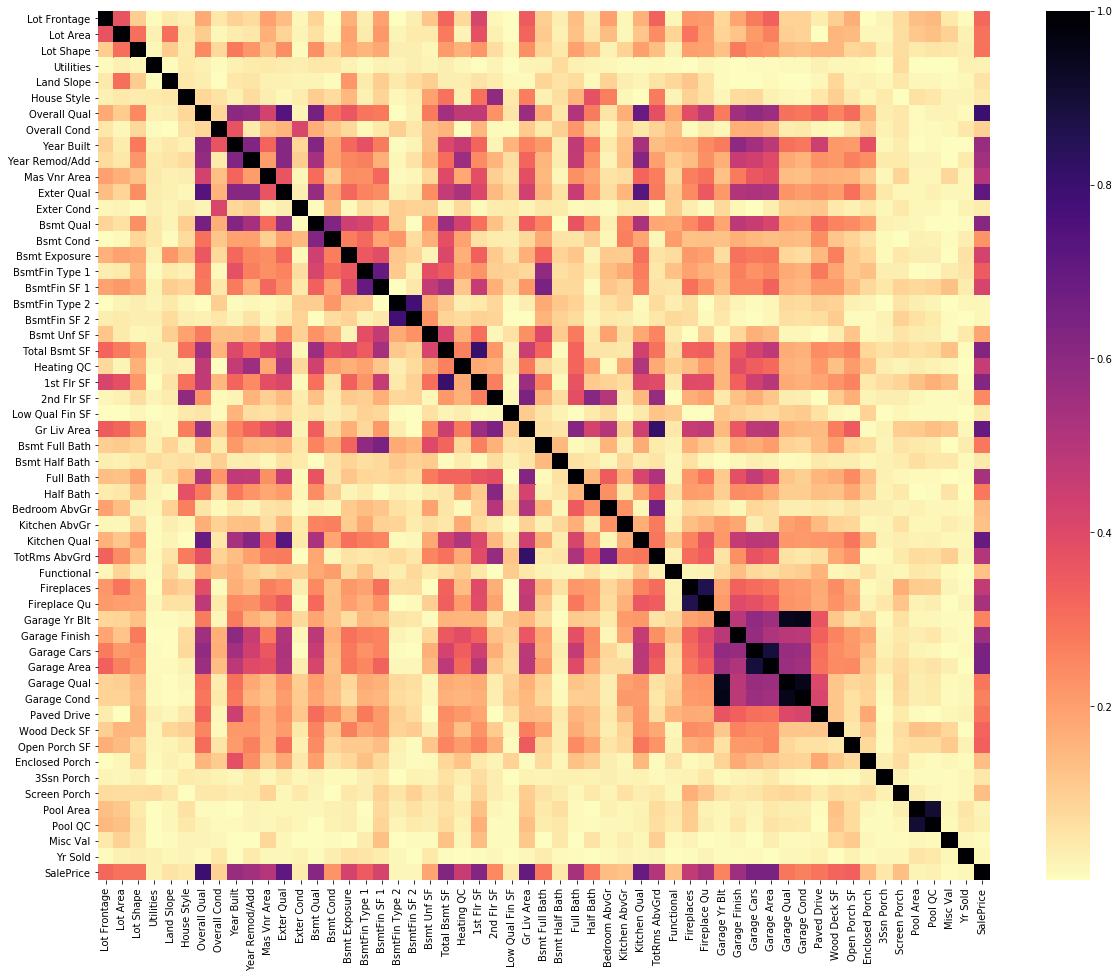

In [78]:
# look at relationships between independent variables via a heatmap
housing1 = housing[num_col].copy() # select only numerical and ordinal category features
housing1['SalePrice']=housing['SalePrice']
fig, ax = plt.subplots(figsize=(20,16))
sns.heatmap(abs(housing1.corr()), cmap='magma_r')

In [79]:
# many variables and high correlations between some independent variables (e.g. quality and condition)
# therefore use lasso to eliminate some factors

In [80]:
# set up independent and dependent variable matrices
X1 = housing1.drop(columns = 'SalePrice') # recall housing 1 only has numerical and ordinal features
y = housing['SalePrice']

# use train-test split to get a hold out set for testing
X1_train, X1_test, y_train, y_test = train_test_split(X1,y, test_size = 0.2, random_state=42)

In [81]:
# scale data so we can use lasso
ss1 = StandardScaler()
ss1.fit(X1_train)
X1_train_scaled = ss1.transform(X1_train)
X1_test_scaled = ss1.transform(X1_test)

In [82]:
# find the best alpha for lasso model
lasso_model = LassoCV(n_alphas = 100)
lasso_model = lasso_model.fit(X1_train_scaled,y_train)
lasso_optimal_alpha = lasso_model.alpha_
lasso_optimal_alpha

1033.9892877027594

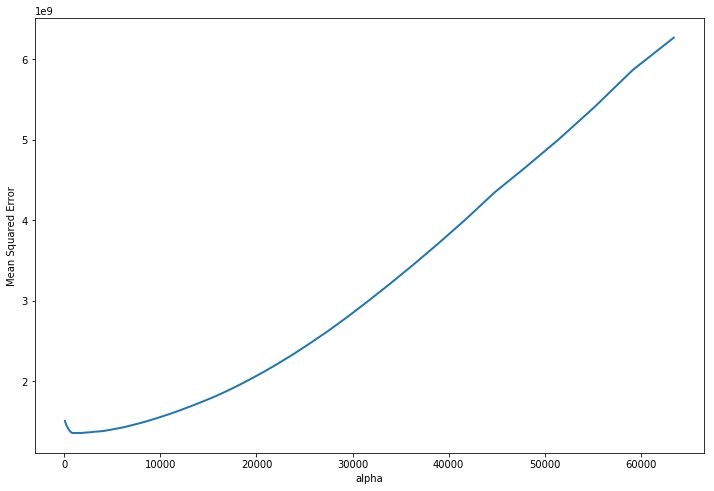

In [83]:
# check optimal alpha on plot - seems large

lasso_cv_means = [np.mean(cv_alpha) for cv_alpha in lasso_model.mse_path_]

# plot alphas vs. MSE
def plot_cv(alphas, cv_means):
    
    fig = plt.figure(figsize=(12,8))
    ax = plt.gca()
    ax.plot(alphas, cv_means, lw=2)
    ax.set_xlabel('alpha')
    ax.set_ylabel('Mean Squared Error')
    
plot_cv(lasso_model.alphas_, lasso_cv_means)

In [84]:
# output looks reasonable
# rerun search for best alpha on tighter search range
l_alphas = np.linspace(950,1050,200)
lasso_model = LassoCV(alphas = l_alphas)
lasso_model = lasso_model.fit(X1_train_scaled,y_train)
lasso_optimal_alpha = lasso_model.alpha_
lasso_optimal_alpha

1014.321608040201

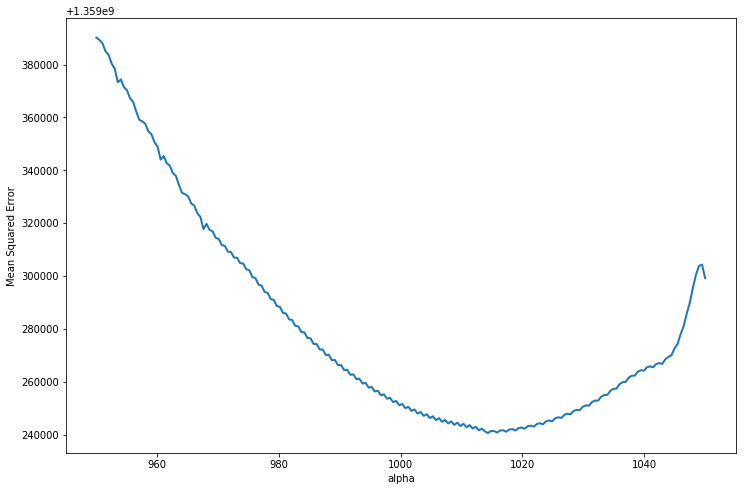

In [85]:
# plot alpha again to check output
lasso_cv_means = [np.mean(cv_alpha) for cv_alpha in lasso_model.mse_path_]
plot_cv(lasso_model.alphas_, lasso_cv_means)

In [86]:
# look at cross validated scores from lasso model with best alpha
lasso_M1 = Lasso(alpha = lasso_optimal_alpha)

print('mean', (-cross_val_score(lasso_M1, X1_train_scaled, y_train, cv=10, scoring='neg_mean_squared_error').mean())**0.5)
print('max', (-cross_val_score(lasso_M1, X1_train_scaled, y_train, cv=10, scoring='neg_mean_squared_error').min())**0.5)
print('min', (-cross_val_score(lasso_M1, X1_train_scaled, y_train, cv=10, scoring='neg_mean_squared_error').max())**0.5)

mean 35544.864850880505
max 56175.75241068305
min 27278.197629347633


In [87]:
# fit best lasso model to whole training set
lasso_M1.fit(X1_train_scaled, y_train);

In [88]:
# RMSE scores on hold out set
predict_test = lasso_M1.predict(X1_test_scaled)
print(metrics.mean_squared_error(y_test, predict_test)**0.5)

26692.231926744727


In [89]:
# predict from test set
X1_fulltest = test[num_col].copy() # select only numerical and ordinal category features
X1_fulltest_scaled = ss1.transform(X1_fulltest)
predict_fulltest = lasso_M1.predict(X1_fulltest_scaled)

# save model output
model1_predict = pd.DataFrame(predict_fulltest, columns=['SalePrice'])
model1_outcomes = pd.concat([test['Id'],model1_predict], axis=1)
model1_outcomes.set_index('Id', inplace=True)
model1_outcomes.to_csv('./Data/model1_submission.csv')

In [90]:
# score: 45200
# Note: score and RMSE of hold out set are VERY different

## Model 2 - Numerical and ordinal categories only, lasso regularisation with higher alpha

In [91]:
# RSME on train and test data varied a lot for model 1
# look for evidence of overfitting

# find number of non-zero coefficients
betas = pd.DataFrame(lasso_M1.coef_, index = X1.columns, columns=['beta'])
sum(betas['beta']!=0)

32

In [92]:
# this seems high
# is there any co-linearity between the remaining variables? - look at heatmap
model1_indep = betas[abs(betas['beta'])!=0].index
model1_obs = housing[model1_indep]
model1_obs['SalePrice'] = housing['SalePrice']

/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


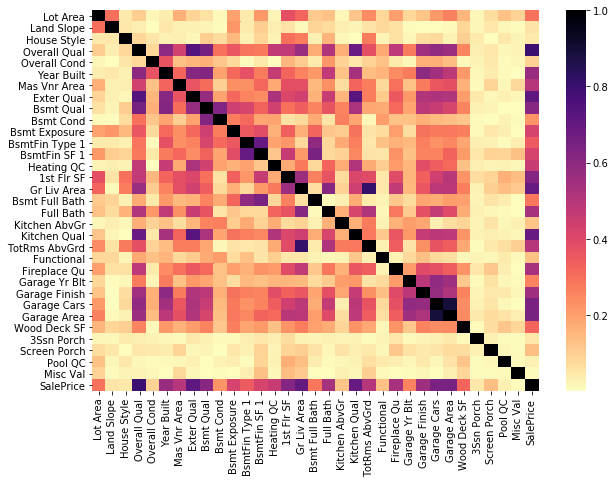

In [93]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(abs(model1_obs.corr()), cmap='magma_r');

In [94]:
# some evidence of overfitting - still have highly correlated variables

In [95]:
# look at various train-test splits to see relationship between alpha and scores

# set up independent and dependent variable matrices
housing2 = housing1.copy() # recall housing1 only has numerical and ordinal category features
X2 = housing2.drop(columns = 'SalePrice')
y = housing['SalePrice']

# record alphas and RMSEs for different random seeds - aim for consistent RMSE of ~ 30k across train/test splits

alpha = []
RMSE_train = []
RMSE_test = []
RMSE_diff = []

for randomseed in range(100):
    # use train-test split to get a hold out set for testing
    X2_train, X2_test, y_train, y_test = train_test_split(X2,y, test_size = 0.2, random_state=randomseed)
    
    # scale data
    ss = StandardScaler()
    ss.fit(X2_train)
    X2_train_scaled = ss.transform(X2_train)
    X2_test_scaled = ss.transform(X2_test)
    
    # find the best alpha for lasso model
    lasso_model = LassoCV(n_alphas = 100)
    lasso_model = lasso_model.fit(X2_train_scaled,y_train)
    lasso_optimal_alpha = lasso_model.alpha_
    lasso_optimal_alpha
    
    # rerun search for best alpha on tighter search range
    l_alphas = np.linspace(lasso_optimal_alpha-200,lasso_optimal_alpha+200,200)
    lasso_model = LassoCV(alphas = l_alphas)
    lasso_model = lasso_model.fit(X2_train_scaled,y_train)
    lasso_optimal_alpha = lasso_model.alpha_
    lasso_optimal_alpha
    
    # fit best lasso model to whole training set
    lasso_opt = Lasso(alpha = lasso_optimal_alpha)
    lasso_opt.fit(X2_train_scaled, y_train)
    
    # RMSE scores
    predict_train = lasso_opt.predict(X2_train_scaled)
    predict_test = lasso_opt.predict(X2_test_scaled)
    train_RMSE = metrics.mean_squared_error(y_train, predict_train)**0.5
    test_RMSE = metrics.mean_squared_error(y_test, predict_test)**0.5
    
    alpha.append(lasso_optimal_alpha) 
    RMSE_train.append(train_RMSE)
    RMSE_test.append(test_RMSE)
    RMSE_diff.append(abs(train_RMSE-test_RMSE))

In [96]:
# turn results into a DataFrame
RMSEs = pd.DataFrame(list(zip(alpha, RMSE_train, RMSE_test, RMSE_diff)), columns=['alpha','RMSE_train', 'RMSE_test', 'RMSE_diff'])

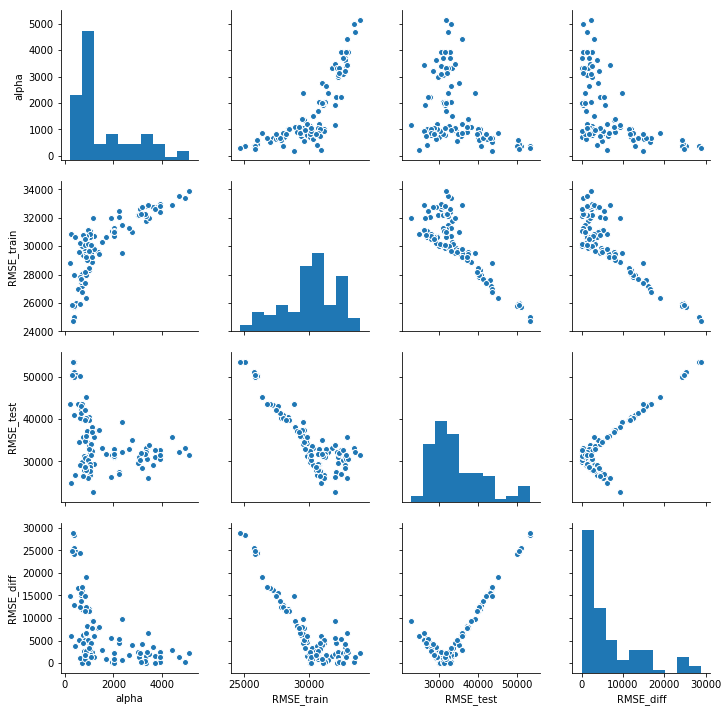

In [97]:
# look at relationships between alpha and RMSE scores
sns.pairplot(RMSEs)

In [98]:
# In general:
#    lower difference between train and test RMSEs seems to correspond with higher alpha
#    lowest difference seems to correspond to RMSE test of ~ 30k
#    higher train RMSE seems to correspond with lower test RMSE - probably because of overfitting
#    can get low test RMSE with very high alpha

In [99]:
# look at alphas with low difference and low test RMSE
RMSEs[(RMSEs['RMSE_diff']<500)& (RMSEs['RMSE_test']<35000)]

alpha    RMSE_train     RMSE_test   RMSE_diff
3   3912.055678  32436.843308  32763.521618  326.678310
22   710.871798  30035.009902  29943.889888   91.120014
25  4969.304255  33416.804187  33068.696419  348.107768
43  3328.751654  32102.081050  32113.071777   10.990727
56   936.144944  30133.360366  30250.182844  116.822478
57  1927.582350  31034.500732  31387.805867  353.305135
63  2045.906457  31223.492988  31687.382687  463.889699
65  3144.721037  32289.545072  31940.522454  349.022617
74  2041.833884  31246.284598  30932.494329  313.790269
81  2013.191691  31071.952029  31175.427856  103.475827
87  3709.474041  32625.870835  32704.616201   78.745365

In [102]:
# scale data
ss2 = StandardScaler()
ss2.fit(X2)
X2_scaled = ss2.transform(X2)

# look at RMSEs from cross validations on range of large alphas on full train set
for alpha in np.linspace(500,15000,30):
    lasso = Lasso(alpha = alpha)
    MSE_mean = -cross_val_score(lasso, X2_scaled, y, cv=10, scoring='neg_mean_squared_error').mean()
    MSE_min = -cross_val_score(lasso, X2_scaled, y, cv=10, scoring='neg_mean_squared_error').max()
    MSE_max = -cross_val_score(lasso, X2_scaled, y, cv=10, scoring='neg_mean_squared_error').min()
    MSE_range = MSE_max**0.5 - MSE_min**0.5
    
    print(alpha, MSE_mean**0.5, MSE_max**0.5, MSE_min**0.5, MSE_range)

500.0 33519.13547048113 49846.00600462611 24076.780356427167 25769.225648198946
1000.0 33438.77127832011 49386.359736618 24084.12990082512 25302.229835792878
1500.0 33547.34587561939 48915.0767433816 24341.429569977114 24573.647173404486
2000.0 33667.46818451314 48433.985530495025 24401.47807031727 24032.507460177756
2500.0 33805.115036991534 47949.31617199306 24510.55560376797 23438.760568225087
3000.0 33905.468545876975 47499.15396847942 24533.47558320796 22965.678385271458
3500.0 34030.34263099152 47001.406682603825 24629.495969652147 22371.910712951678
4000.0 34158.348847362446 46510.69768970623 24763.529116188718 21747.16857351751
4500.0 34303.554868882384 45942.50879289841 25040.714624071446 20901.79416882696
5000.0 34475.181609222076 45402.99385801431 25346.59534582653 20056.398512187785
5500.0 34665.002721350094 44893.428445568345 25617.421377274164 19276.00706829418
6000.0 34862.64684053011 44414.928426688995 25891.056609444804 18523.87181724419
6500.0 35061.91233496349 43968.

In [103]:
# fit model with alpha of 8000
lasso_M2 = Lasso(alpha = 8000)
lasso_M2.fit(X2_scaled,y)

# look at number of non-zero coefficients
betas = pd.DataFrame(lasso_M2.coef_, index = X2.columns, columns=['beta'])
sum(betas['beta']!=0)

14

In [104]:
# we're left with a lot less variables, which could help overfitting

In [105]:
# fit predictions
X2_fulltest = test[num_col].copy()
X2_fulltest_scaled = ss2.transform(X2_fulltest)
predict_fulltest = lasso_M2.predict(X2_fulltest_scaled)

# save model output
model2_predict = pd.DataFrame(predict_fulltest, columns=['SalePrice'])
model2_outcomes = pd.concat([test['Id'],model2_predict], axis=1)
model2_outcomes.set_index('Id', inplace=True)
model2_outcomes.to_csv('./Data/model2_submission.csv')

In [106]:
# score: 45100
# seems this didn't help very much

## Model 3 - Model 1 but removing some co-linear features before running lasso

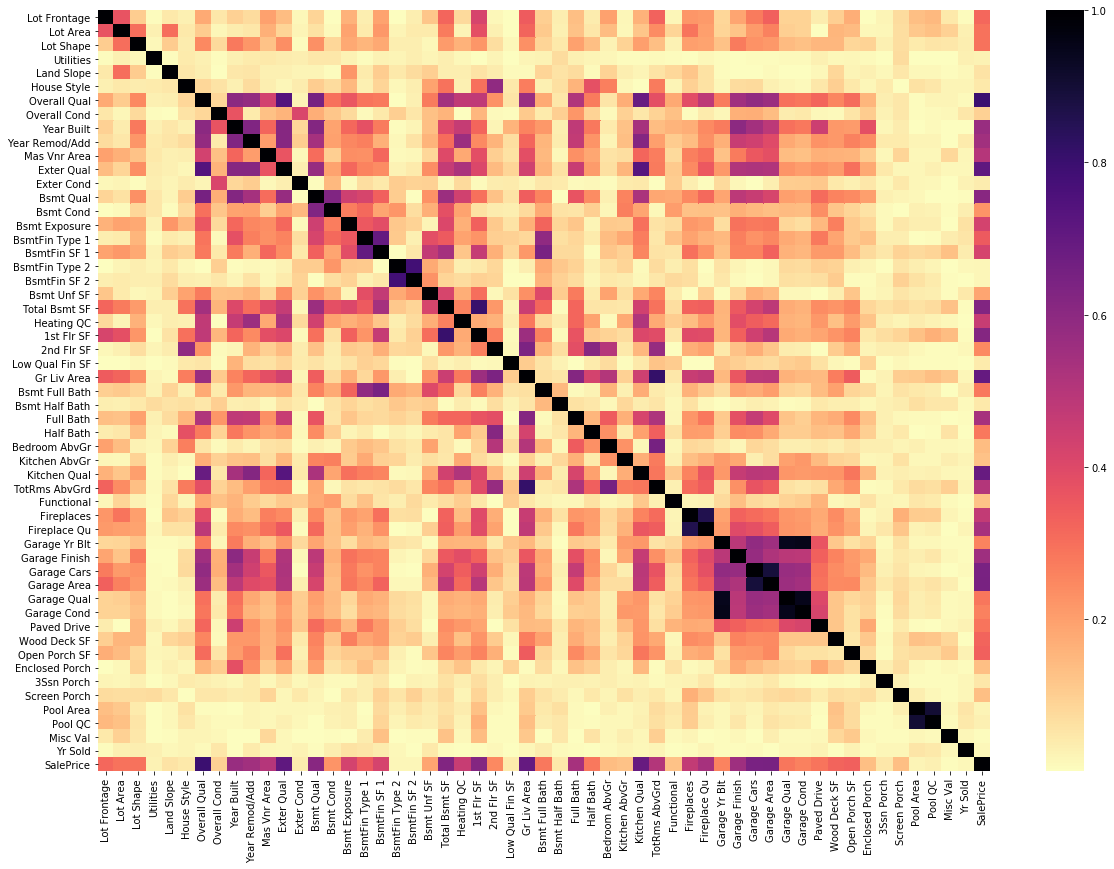

In [107]:
# RSME on train and test data still varied a lot for model 2, despite the high alpha lasso
# maybe there is still co-linearity between the remaining variables - look at heatmap

housing3 = housing[num_col].copy() # select numerical and ordinal category features
housing3['SalePrice']=housing['SalePrice']
fig, ax = plt.subplots(figsize=(20,14))
sns.heatmap(abs(housing1.corr()), cmap='magma_r');

In [108]:
# iterate through correlations and print pairs of variables that are highly correlated
from itertools import combinations
for combo in combinations(housing3.columns, 2):
    if abs(housing.corr()[list(combo)[0]][list(combo)[1]])>0.70:
        print(list(combo))

['Overall Qual', 'Exter Qual']
['Overall Qual', 'SalePrice']
['Exter Qual', 'Kitchen Qual']
['Exter Qual', 'SalePrice']
['BsmtFin Type 2', 'BsmtFin SF 2']
['Total Bsmt SF', '1st Flr SF']
['Gr Liv Area', 'TotRms AbvGrd']
['Fireplaces', 'Fireplace Qu']
['Garage Yr Blt', 'Garage Qual']
['Garage Yr Blt', 'Garage Cond']
['Garage Cars', 'Garage Area']
['Garage Qual', 'Garage Cond']
['Pool Area', 'Pool QC']


In [109]:
# drop some columns from the pairs above to reduce co-linearity
drop_cols = ['Pool QC','Garage Cars','Garage Yr Blt','Garage Qual','Fireplace Qu','TotRms AbvGrd','Total Bsmt SF','BsmtFin Type 2', 'SalePrice', 'Exter Qual']
X3 = housing3.drop(columns=drop_cols, axis=1)

In [110]:
# scale the data so we can use lasso
ss3 = StandardScaler()
ss3.fit(X3)
X3_scaled = ss3.transform(X3)

In [111]:
# find the best alpha for lasso model
lasso_model = LassoCV(n_alphas = 500)
lasso_model = lasso_model.fit(X3_scaled,y)
lasso_optimal_alpha = lasso_model.alpha_
lasso_optimal_alpha

798.6260992583092

In [112]:
# rerun search for best alpha on tighter search range
l_alphas = np.linspace(700,900,200)
lasso_model = LassoCV(alphas = l_alphas)
lasso_model = lasso_model.fit(X3_scaled,y)
lasso_optimal_alpha = lasso_model.alpha_
lasso_optimal_alpha

796.4824120603015

In [113]:
# look at cross validated scores from lasso model with best alpha
lasso_M3 = Lasso(alpha = lasso_optimal_alpha)
print('mean', (-cross_val_score(lasso_M3, X3_scaled, y, cv=10, scoring='neg_mean_squared_error').mean())**0.5)
print('max', (-cross_val_score(lasso_M3, X3_scaled, y, cv=10, scoring='neg_mean_squared_error').min())**0.5)
print('min', (-cross_val_score(lasso_M3, X3_scaled, y, cv=10, scoring='neg_mean_squared_error').max())**0.5)

mean 33649.46897599766
max 48431.84993096894
min 24852.892695983875


In [114]:
# fit model and look at number of non-zero coefficients
lasso_M3.fit(X3_scaled,y)
betas = pd.DataFrame(lasso_M3.coef_, index = X3.columns, columns=['beta'])
sum(betas['beta']!=0)

32

In [115]:
# fit predictions
X3_fulltest = test[X3.columns].copy()
X3_fulltest_scaled = ss3.transform(X3_fulltest)
predict_fulltest = lasso_M3.predict(X3_fulltest_scaled)

# save model output
model3_predict = pd.DataFrame(predict_fulltest, columns=['SalePrice'])
model3_outcomes = pd.concat([test['Id'],model3_predict], axis=1)
model3_outcomes.set_index('Id', inplace=True)
model3_outcomes.to_csv('./Data/model3_submission.csv')

In [116]:
# score: 40957
# quite an improvement!

## Model 4 - Model 3 with higher alpha

In [118]:
# as for model 2, look at the effect of using higher alpha values

# start model off to be the same as model 3
X4 = X3.copy()
X4_scaled = X3_scaled.copy()
ss4 = ss3

# look at RMSEs from cross validations on range of large alphas on full train set
for alpha in np.linspace(500,15000,30):
    lasso = Lasso(alpha = alpha)
    MSE_mean = -cross_val_score(lasso, X4_scaled, y, cv=10, scoring='neg_mean_squared_error').mean()
    MSE_min = -cross_val_score(lasso, X4_scaled, y, cv=10, scoring='neg_mean_squared_error').max()
    MSE_max = -cross_val_score(lasso, X4_scaled, y, cv=10, scoring='neg_mean_squared_error').min()
    MSE_range = MSE_max**0.5 - MSE_min**0.5
    
    print(alpha, MSE_mean**0.5, MSE_max**0.5, MSE_min**0.5, MSE_range)

500.0 33814.96469378034 49622.83163879372 24964.607814386345 24658.223824407378
1000.0 33636.57963369326 48033.924378180476 24844.082028747078 23189.8423494334
1500.0 33761.52563568943 47516.305293743055 24945.445426848008 22570.859866895047
2000.0 33867.94077260998 47164.87431761228 24907.229065650685 22257.645251961596
2500.0 34028.09438972342 46889.20574547667 24909.42287631895 21979.78286915772
3000.0 34182.57447370406 46412.4370998096 25008.31598091173 21404.121118897867
3500.0 34293.41610709424 45936.807404321975 25076.73284195875 20860.074562363225
4000.0 34434.29364457459 45452.39195557563 25248.04554978105 20204.34640579458
4500.0 34604.31934393893 44937.67321436971 25503.820730185776 19433.85248418393
5000.0 34801.09561024178 44452.00327253436 25798.125455612077 18653.877816922286
5500.0 35016.557537560235 43997.597563631454 26078.337503138115 17919.26006049334
6000.0 35233.29204911764 43574.81766335537 26373.482559820604 17201.335103534762
6500.0 35449.891373303304 43178.420

In [119]:
# fit model with alpha of 8000, which corresponds to lowest difference in train/test RMSEs above
lasso_M4 = Lasso(alpha = 8000)
lasso_M4.fit(X4_scaled, y)

# look at number of non-zero coefficients
betas = pd.DataFrame(lasso_M4.coef_, index = X4.columns, columns=['beta'])
sum(betas['beta']!=0)

12

In [120]:
# we're left with a lot less variables, which could help overfitting

In [121]:
# fit model to test data
X4_fulltest = test[X4.columns].copy() # select relevant features only
X4_fulltest_scaled = ss4.transform(X4_fulltest)
predict_fulltest = lasso_M4.predict(X4_fulltest_scaled)

# save model output
model4_predict = pd.DataFrame(predict_fulltest, columns=['SalePrice'])
model4_outcomes = pd.concat([test['Id'],model4_predict], axis=1)
model4_outcomes.set_index('Id', inplace=True)
model4_outcomes.to_csv('./Data/model4_submission.csv')

In [122]:
# score: 45000
# this made it worse

## Model 5 - Model 3 plus relevant flags from categorical columns

In [123]:
# get a list of categorical features
cat_cols = list(housing.drop(columns=num_col, axis=1).columns)
cat_cols.remove('PID')
cat_cols.remove('SalePrice')
cat_cols

['MS SubClass',
 'MS Zoning',
 'Street',
 'Alley',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Foundation',
 'Heating',
 'Central Air',
 'Electrical',
 'Garage Type',
 'Fence',
 'Misc Feature',
 'Mo Sold',
 'Sale Type']

In [124]:
# add M3 predictions and residuals to housing table
housing_add_M3_predict = housing.copy()
housing_add_M3_predict['M3_price_predict'] = lasso_M3.predict(X3_scaled)
housing_add_M3_predict['Residuals'] = abs(housing_add_M3_predict['M3_price_predict']-housing_add_M3_predict['SalePrice'])

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


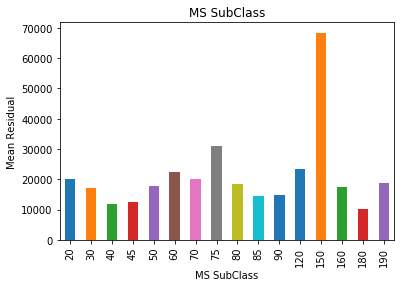

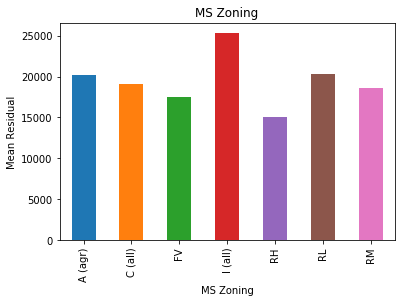

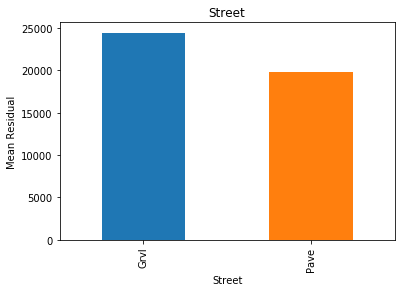

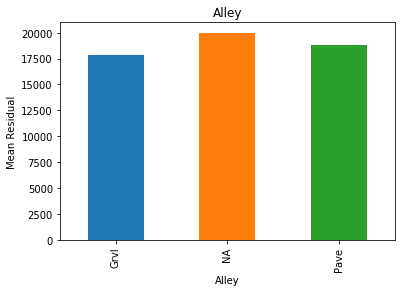

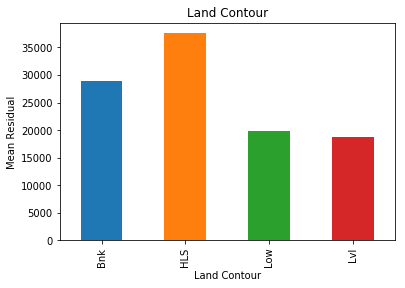

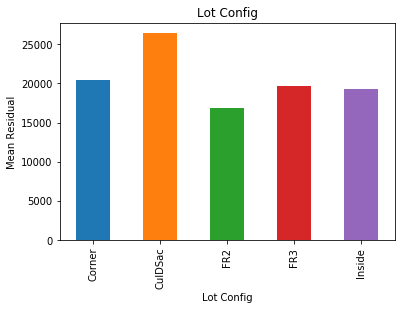

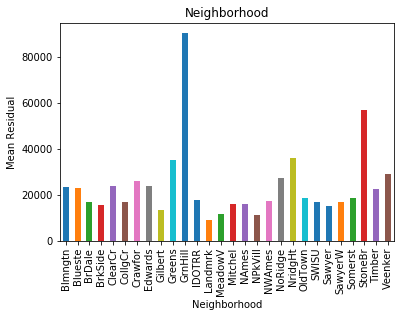

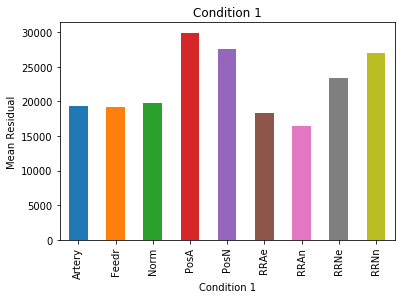

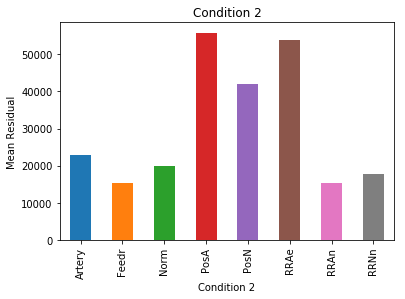

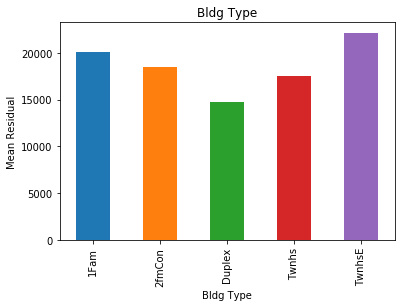

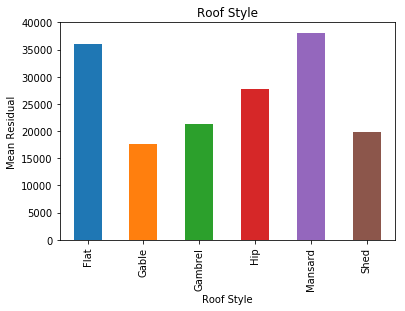

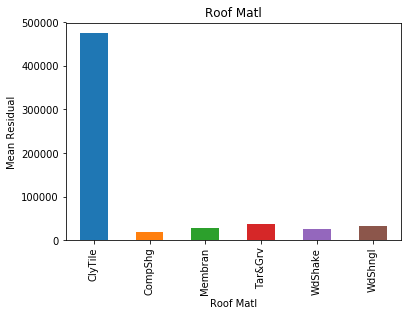

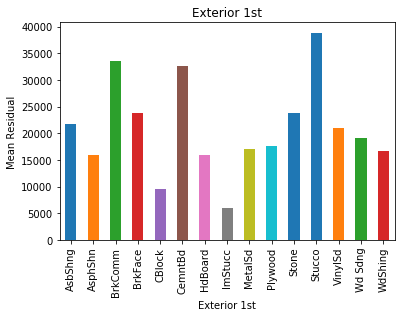

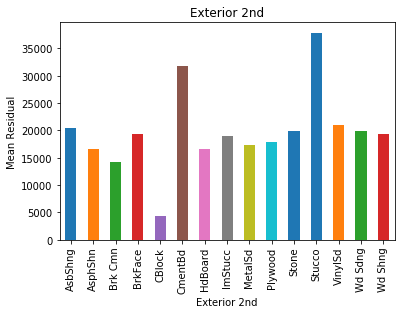

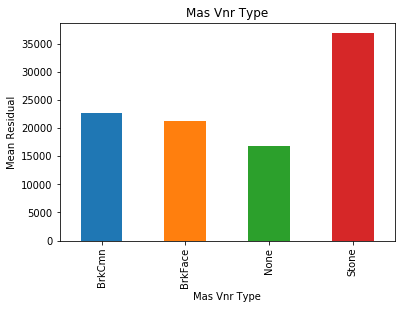

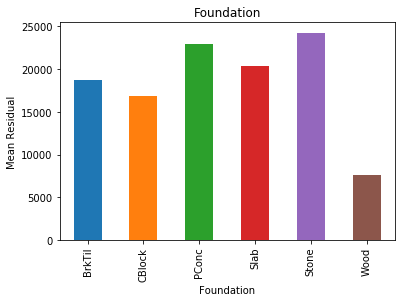

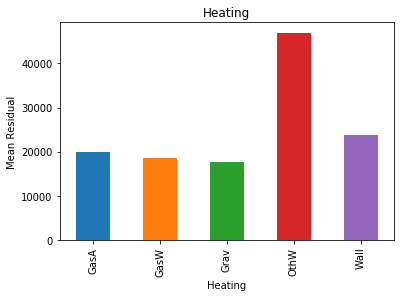

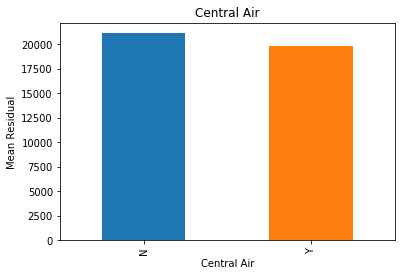

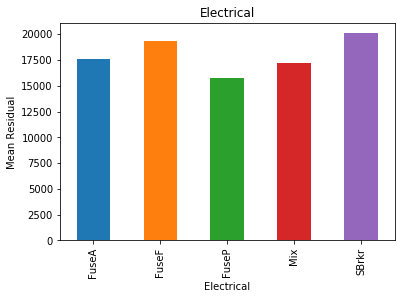

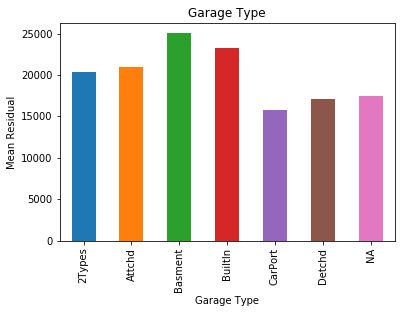

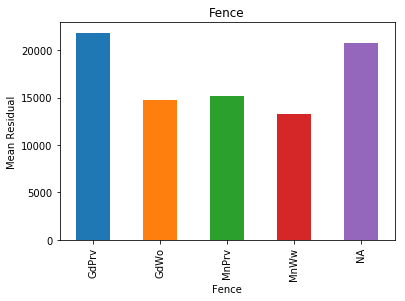

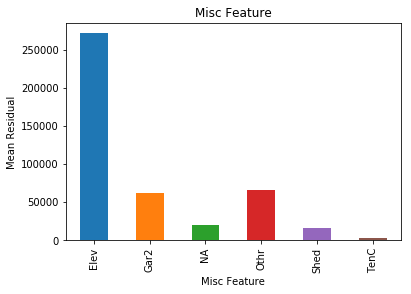

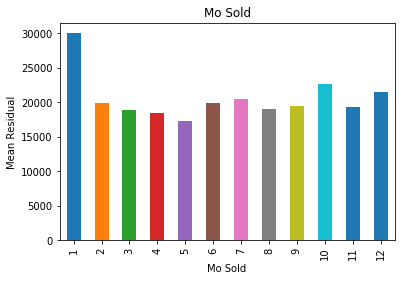

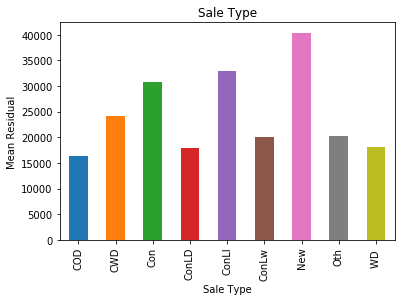

In [125]:
# plot mean residual by category for each categorical column, based on model 3 predictions
for variable in cat_cols: 
    fig, ax = plt.subplots()
    ax = plt.gca()
    (housing_add_M3_predict.groupby(variable)['Residuals'].mean()).plot.bar()
    ax.set_title(variable)
    ax.set_ylabel('Mean Residual')

In [126]:
# variables where mean residuals vary alot across different category values are:
#    MS SubClass - Class 150 stands out as being incorrectly priced (up to 70k mean) - flag
#    Neighbourhood - GrnHill and StoneBr in particular are incorrectly priced (up to 90k mean) - flags
#    Condition 2 - PosA and RRAe in particular are incorrectly prices (up to 60k mean) - ignore for now
#    Roof Matl - ClyTile stands out as being incorrectly priced (up to nearly 500k mean) - flag
#    Heating - OthW stands out as being incorrectly prices (up to 50k mean) - flag
#    Misc Feature - Elev stands out as being incorrectly prices (up to 260k mean) - flag

In [127]:
# set up features dataframe for model 5 with numerical and ordinal category features
X5 = X3.copy()

# function to add categorical flags to dataframe, for categories that we are mis-pricing

def add_flags(features_df, full_df):
    
    # add flag for MS SubClass 150
    features_df['Class 150 Flag'] = full_df['MS SubClass'].map(lambda x: 1 if x==150 else 0)
    
    # add flag for clay roof
    features_df['Clay Roof Flag'] = full_df['Roof Matl'].map(lambda x: 1 if x=='ClyTile' else 0)
    
    # add flag for OthW Heating
    features_df['OthW Heating Flag'] = full_df['Heating'].map(lambda x: 1 if x=='OthW' else 0)
    
    # add flag for elevator
    features_df['Elevator Flag'] = full_df['Misc Feature'].map(lambda x: 1 if x=='Elev' else 0)
    
    # add flags for GrnHill and StoneBr
    features_df['Green Hill Flag'] = full_df['Neighborhood'].map(lambda x: 1 if x=='GrnHill' else 0)
    features_df['Stone Brook Flag'] = full_df['Neighborhood'].map(lambda x: 1 if x=='StoneBr' else 0)
    

In [128]:
# add select category flags to model 5 features dataframe
add_flags(X5, housing)

In [129]:
# check we've got the right columns
X5.columns

Index(['Lot Frontage', 'Lot Area', 'Lot Shape', 'Utilities', 'Land Slope',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Mas Vnr Area', 'Exter Cond', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Heating QC', '1st Flr SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Kitchen Qual', 'Functional', 'Fireplaces', 'Garage Finish',
       'Garage Area', 'Garage Cond', 'Paved Drive', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'Yr Sold', 'Class 150 Flag', 'Clay Roof Flag',
       'OthW Heating Flag', 'Elevator Flag', 'Green Hill Flag',
       'Stone Brook Flag'],
      dtype='object')

In [130]:
# scale X5 so we can use lasso
ss5 = StandardScaler()
ss5.fit(X5)
X5_scaled = ss5.transform(X5)

In [131]:
# look for optimal alpha
lasso_model = LassoCV(n_alphas=500)
lasso_model = lasso_model.fit(X5_scaled, y)
lasso_model_optimal_alpha = lasso_model.alpha_
lasso_model_optimal_alpha

755.6060084987021

In [132]:
# look for optimal alpha on a tighter range
l_alphas = np.linspace(700,800,100)
lasso_model = LassoCV(alphas=l_alphas)
lasso_model = lasso_model.fit(X5_scaled,y)
lasso_model_optimal_alpha = lasso_model.alpha_
lasso_model_optimal_alpha

747.4747474747475

In [133]:
# fit lasso model and look at cross validated scores from lasso model with best alpha
lasso_M5 = Lasso(alpha=lasso_model_optimal_alpha)
print('mean', (-cross_val_score(lasso_M5, X5_scaled, y, cv=10, scoring='neg_mean_squared_error').mean())**0.5)
print('max', (-cross_val_score(lasso_M5, X5_scaled, y, cv=10, scoring='neg_mean_squared_error').min())**0.5)
print('min', (-cross_val_score(lasso_M5, X5_scaled, y, cv=10, scoring='neg_mean_squared_error').max())**0.5)

# find number of non-zero coefficients
lasso_M5.fit(X5_scaled, y)
betas = pd.DataFrame(lasso_M5.coef_, index = X5.columns, columns=['beta'])
sum(betas['beta']!=0)

mean 32642.915298191518
max 50346.32278811695
min 23971.711399268515


37

In [134]:
# select only numerical and ordinal category features from test data
X5_fulltest = test[X3.columns].copy()
# add select category flags to test data
add_flags(X5_fulltest, test)

# fit model to test data
X5_fulltest_scaled = ss5.transform(X5_fulltest)
predict_fulltest = lasso_M5.predict(X5_fulltest_scaled)

# save data
model5_predict = pd.DataFrame(predict_fulltest, columns=['SalePrice'])
model5_outcomes = pd.concat([test['Id'],model5_predict], axis=1)
model5_outcomes.set_index('Id', inplace=True)
model5_outcomes.to_csv('./Data/model5_submission.csv')

In [135]:
# score: 39727

## Model 6 - Model 5 with select dummies

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


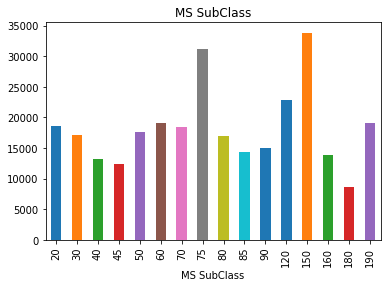

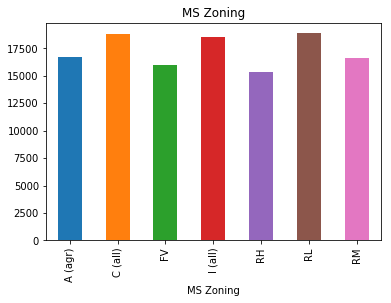

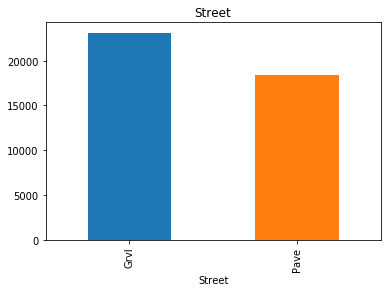

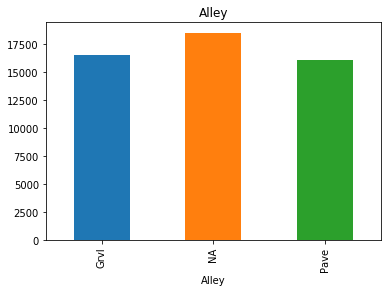

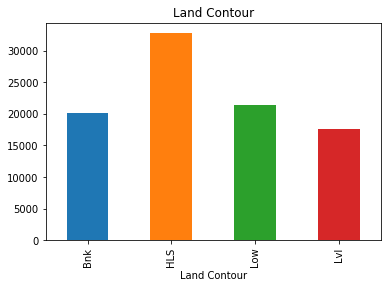

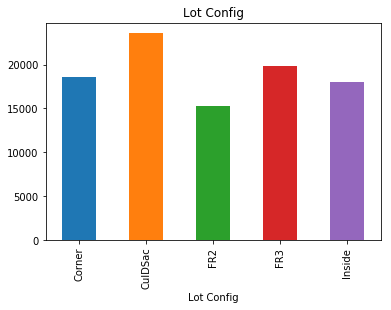

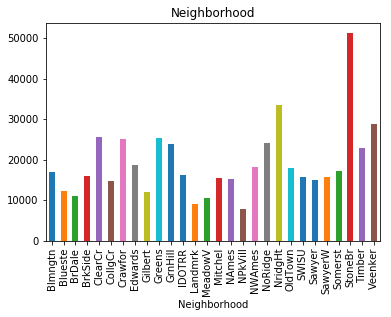

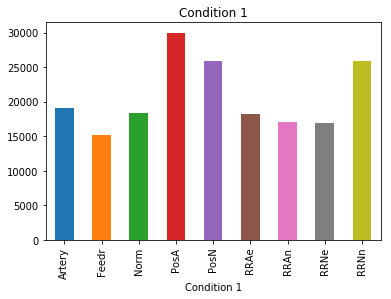

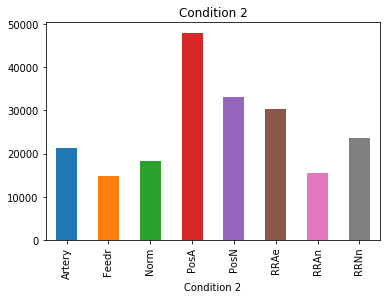

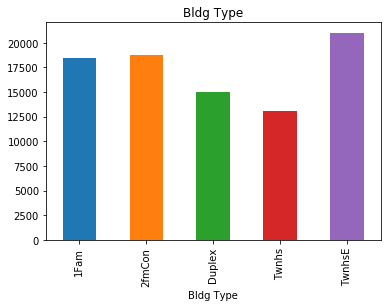

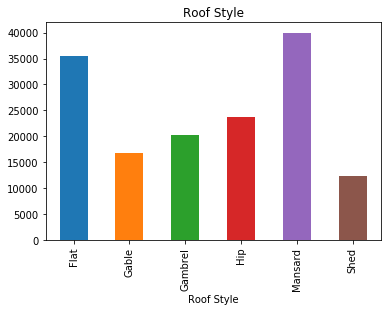

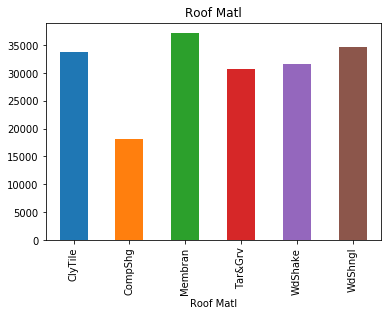

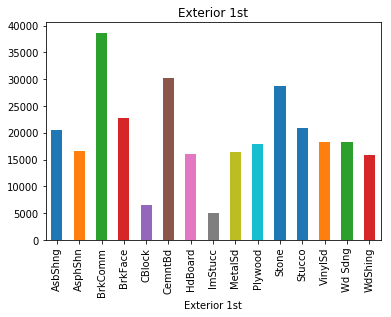

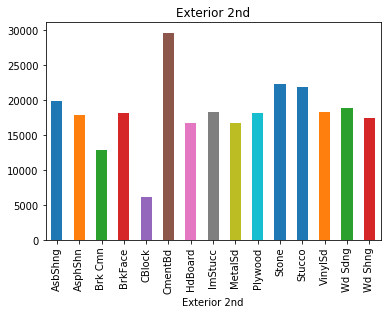

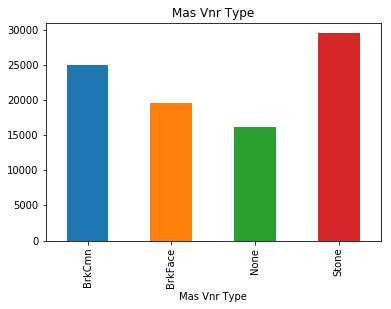

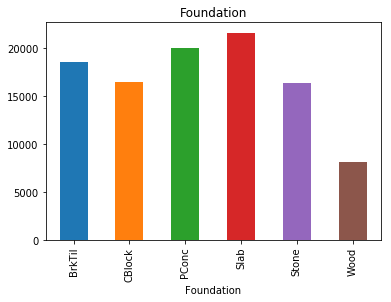

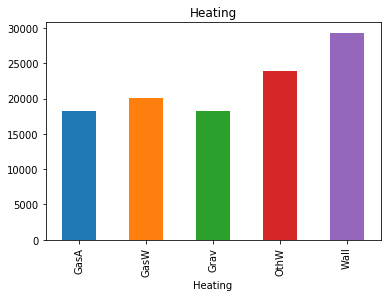

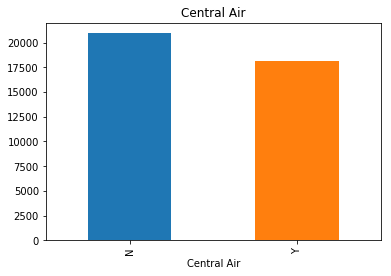

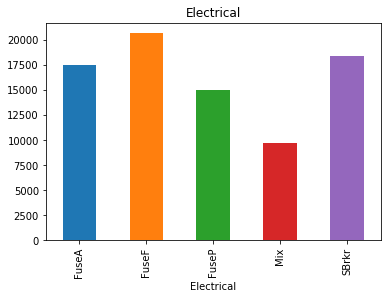

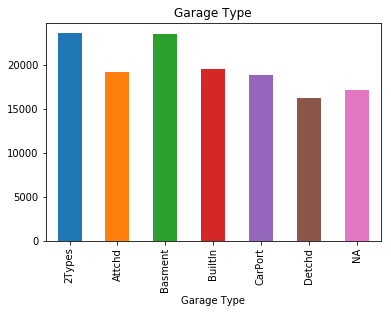

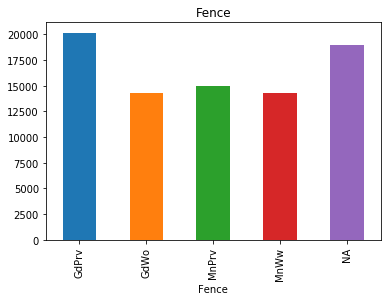

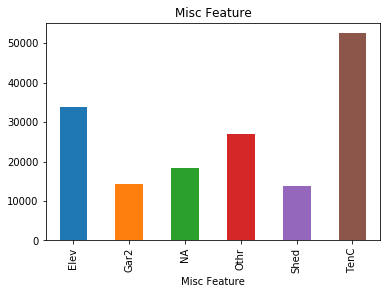

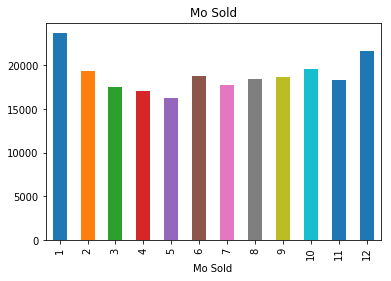

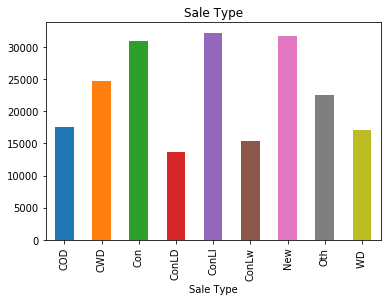

In [136]:
# plot mean residual by category for each categorical column, based on model 5 predictions
housing_add_M5_predict = housing.copy()
housing_add_M5_predict['M5_price_predict'] = lasso_M5.predict(X5_scaled)
housing_add_M5_predict['Residuals'] = abs(housing_add_M5_predict['M5_price_predict']-housing_add_M5_predict['SalePrice'])

for variable in cat_cols: 
    fig, ax = plt.subplots()
    ax = plt.gca()
    (housing_add_M5_predict.groupby(variable)['Residuals'].mean()).plot.bar()
    ax.set_title(variable)


In [137]:
# have improved mean residuals over flagged categories

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


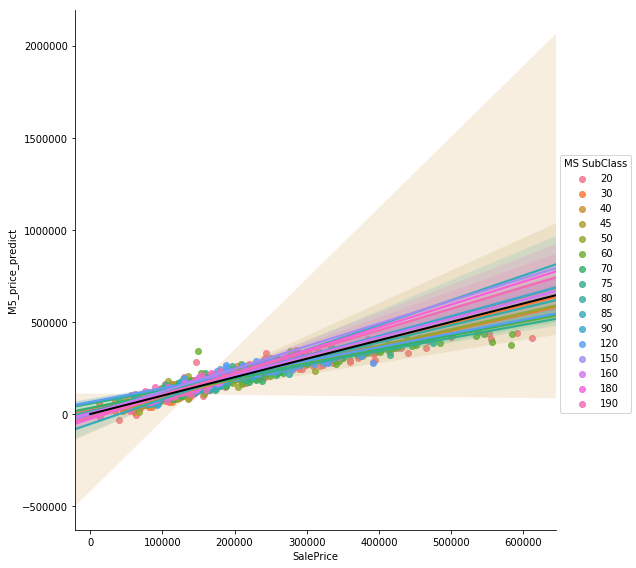

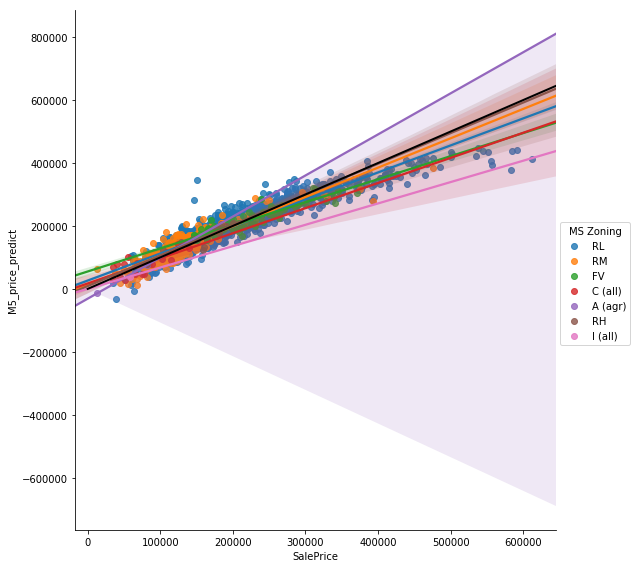

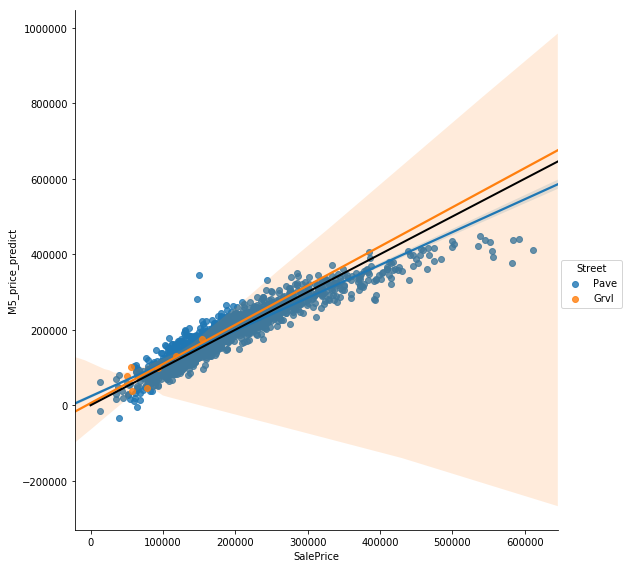

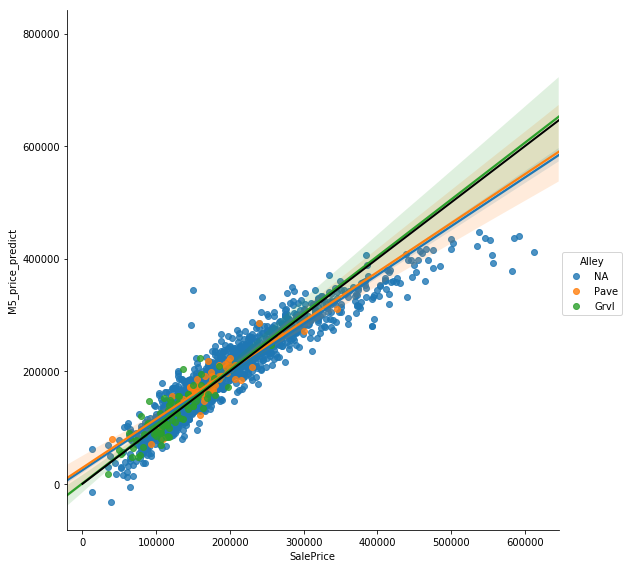

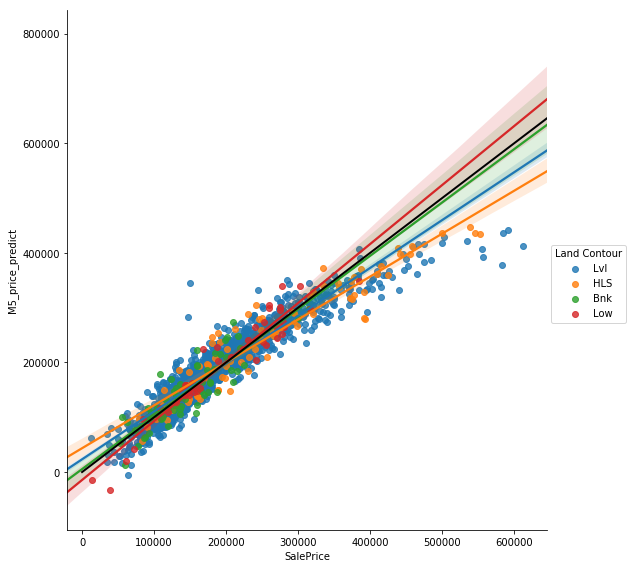

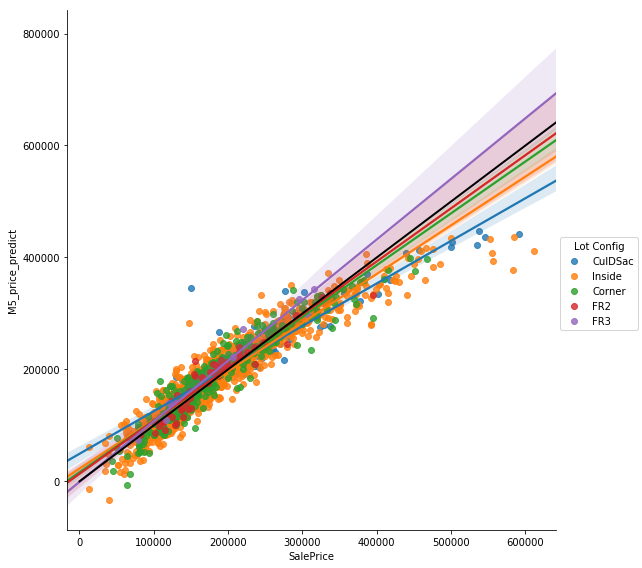

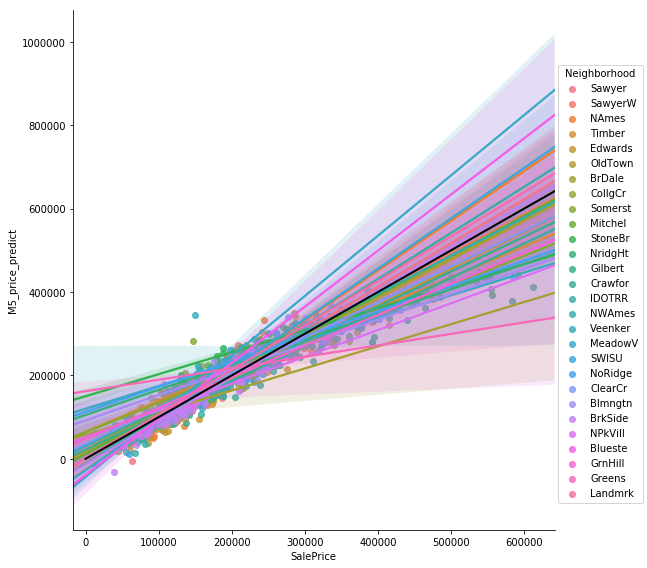

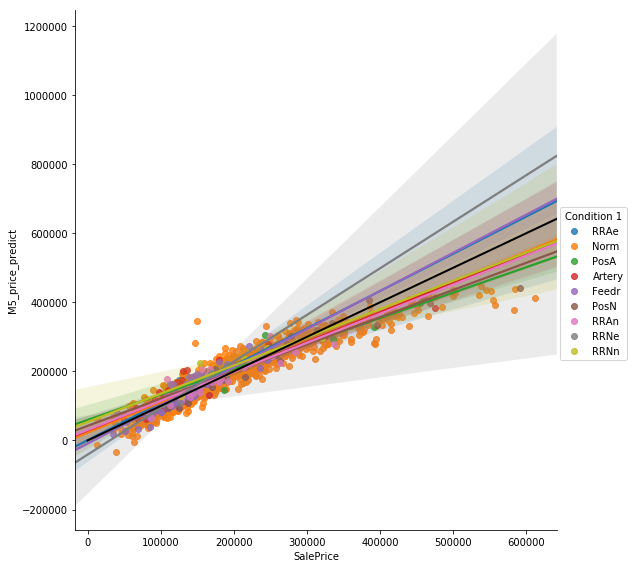

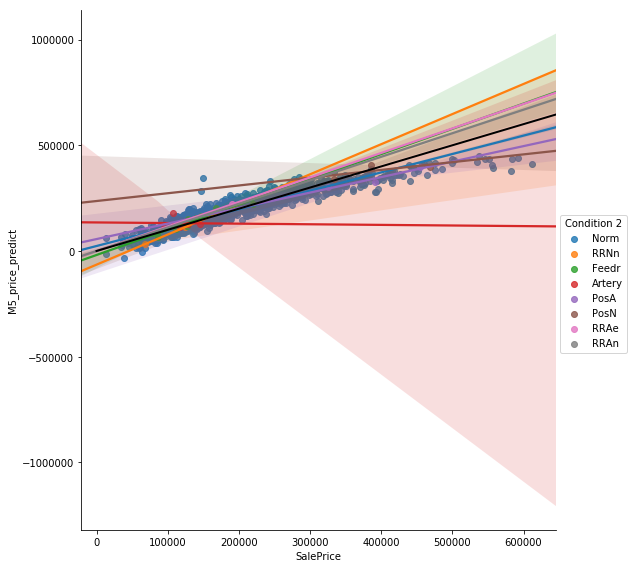

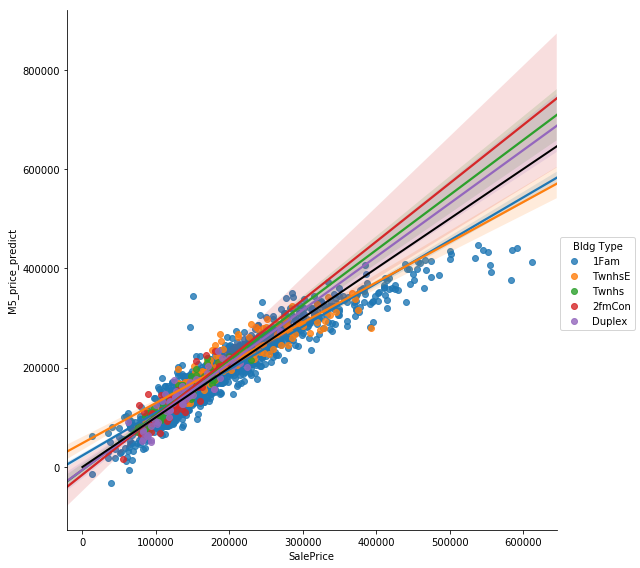

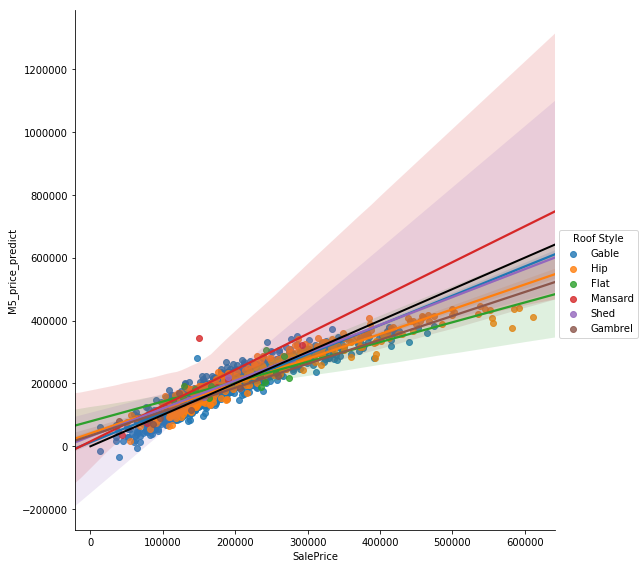

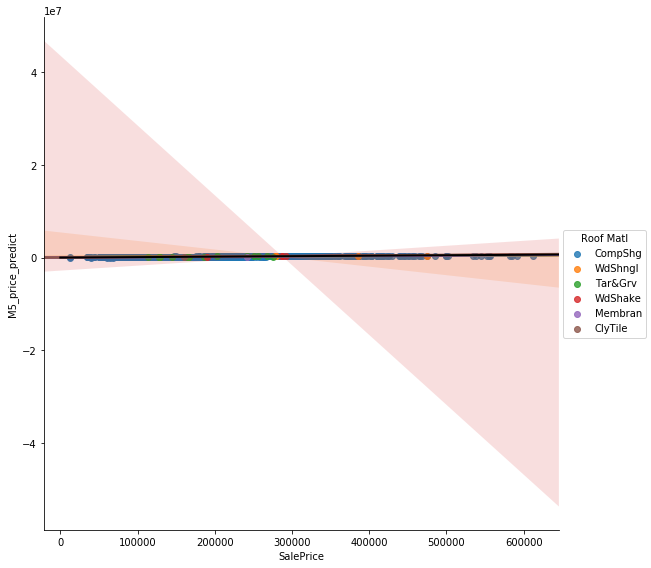

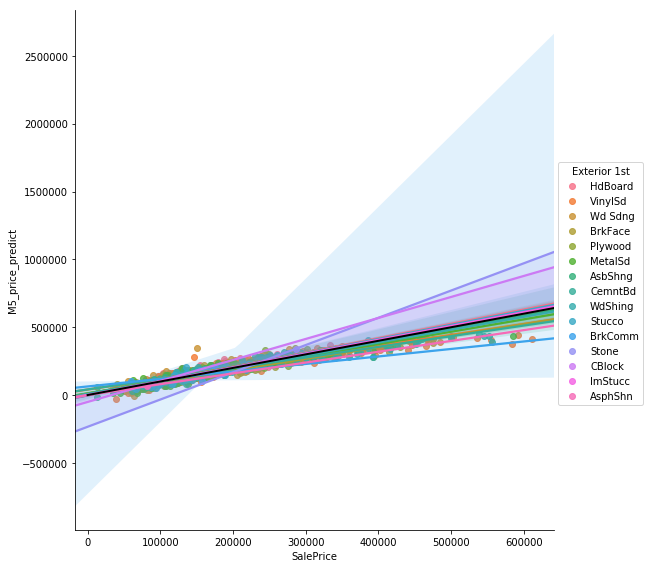

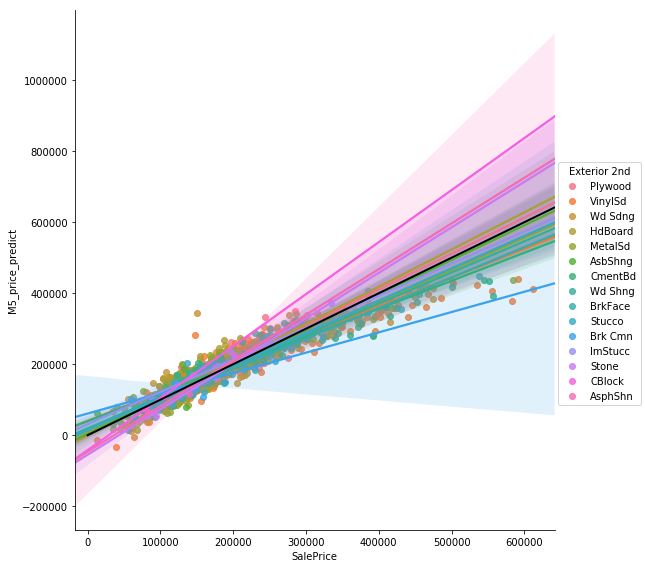

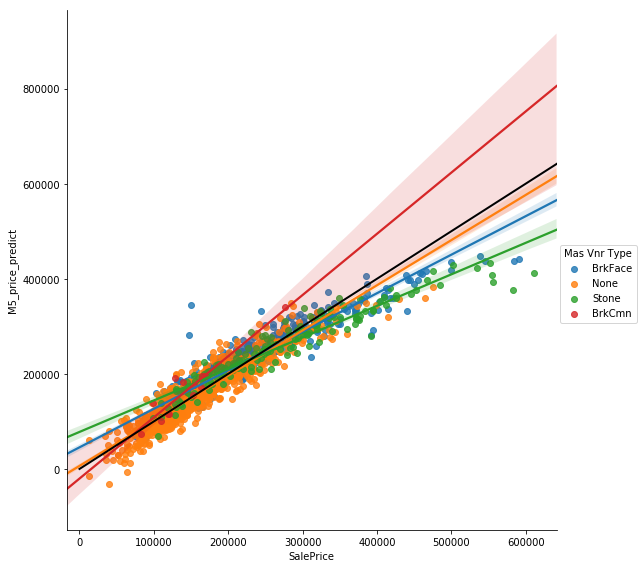

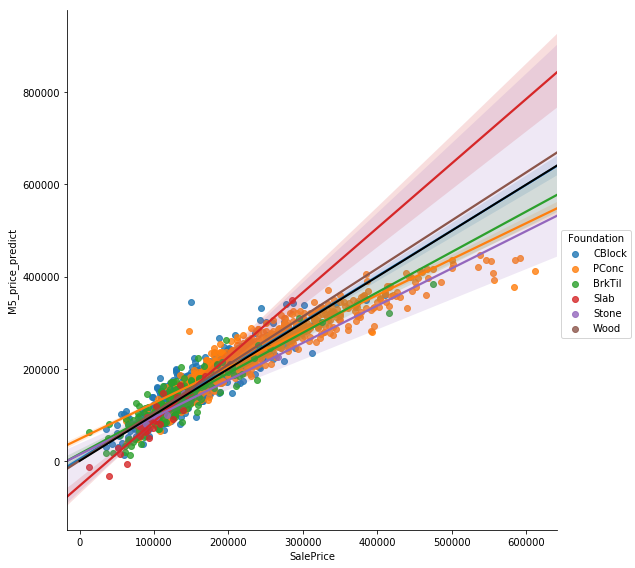

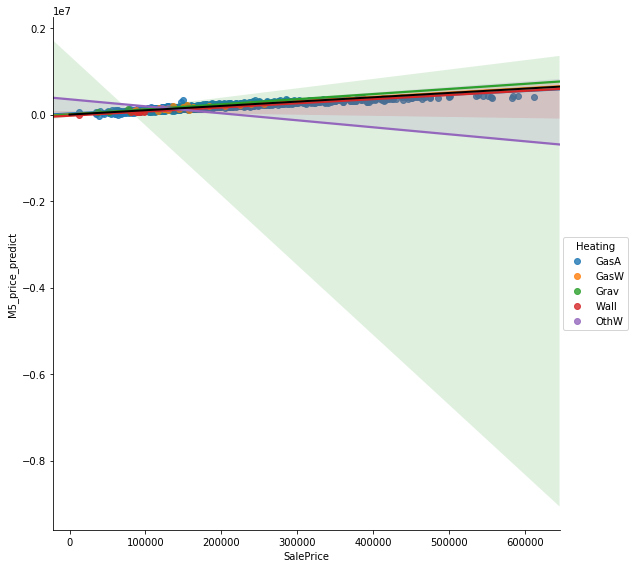

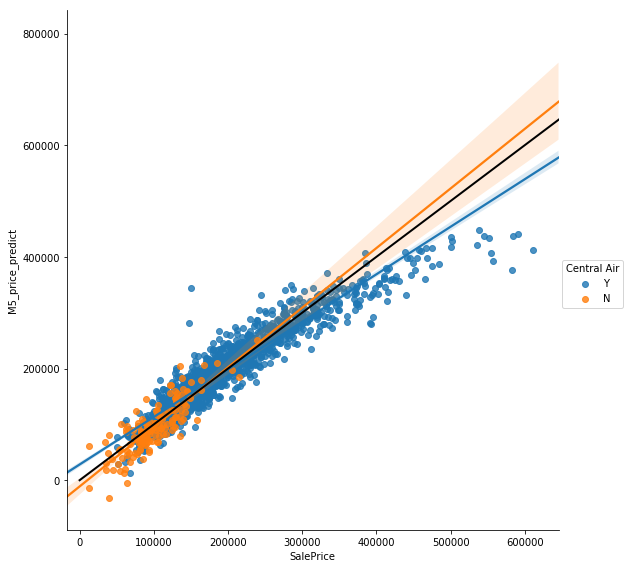

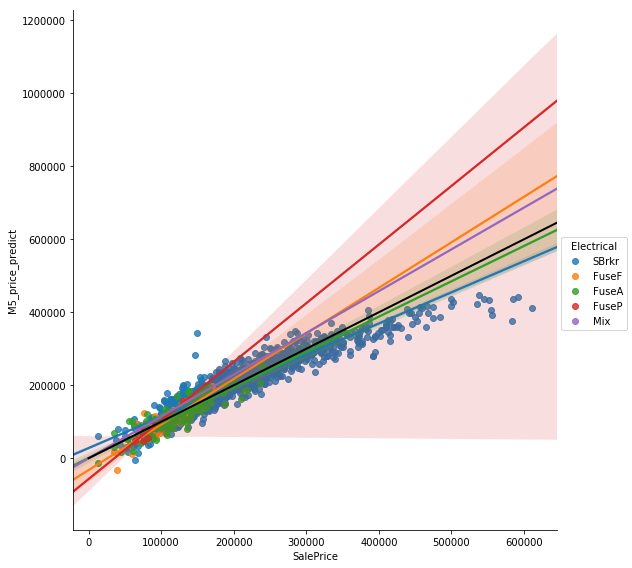

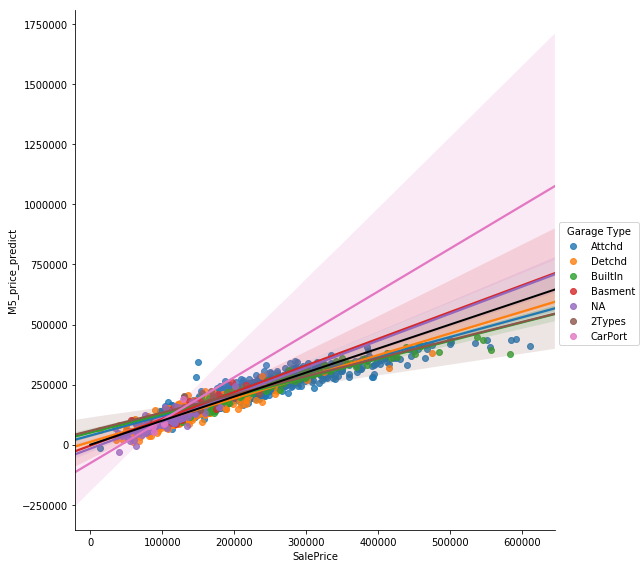

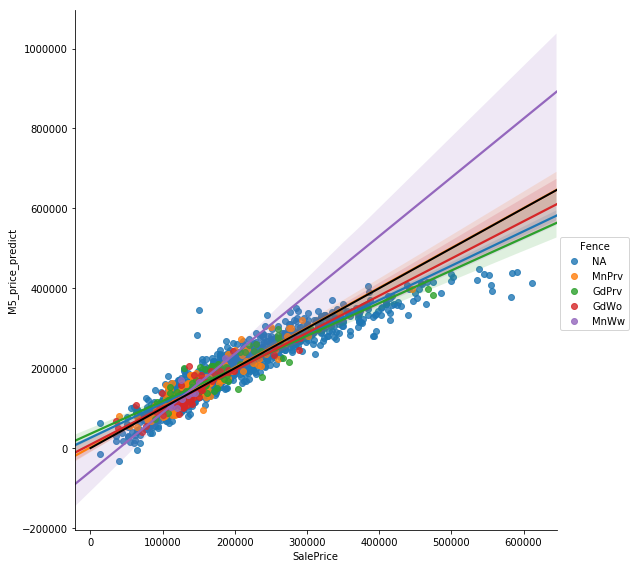

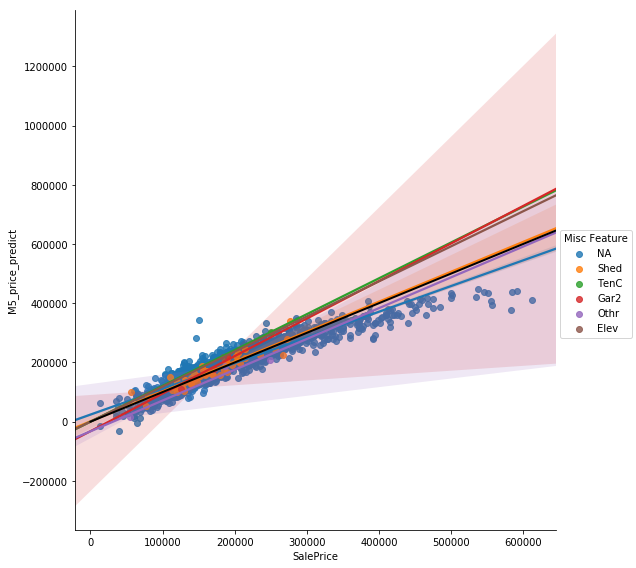

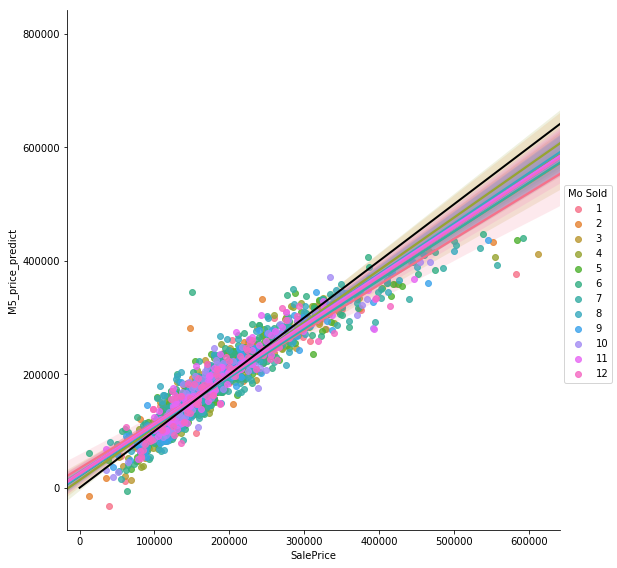

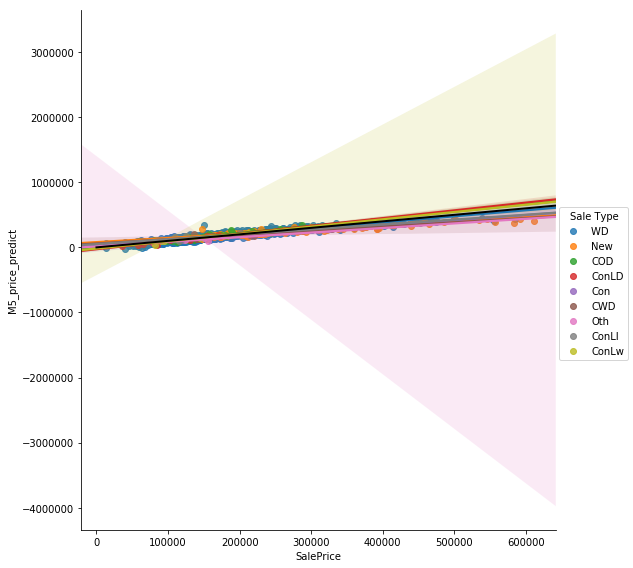

In [138]:
# check which categories in general map the badly fitted data
for variable in cat_cols: 
    sns.lmplot('SalePrice','M5_price_predict',housing_add_M5_predict, hue = variable, size=8)
    plt.plot([0, 800000], [0, 800000], '-', color="black", lw=2, zorder=10)

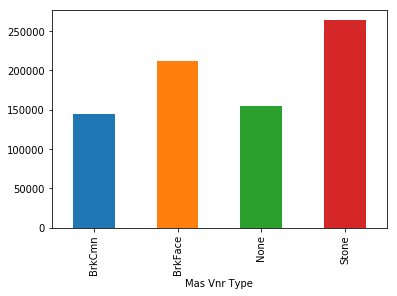

In [139]:
# Potential categories to add: Mas Vnr Type, Lot Config, Roof Style

# Look whether they're a differentiator in price
(housing_add_M5_predict.groupby('Mas Vnr Type')['SalePrice'].mean()).plot.bar();

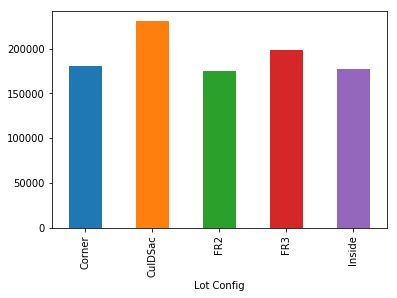

In [140]:
(housing_add_M5_predict.groupby('Lot Config')['SalePrice'].mean()).plot.bar();

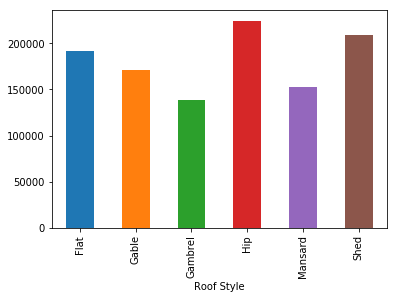

In [141]:
(housing_add_M5_predict.groupby('Roof Style')['SalePrice'].mean()).plot.bar();

In [142]:
# add dummies for Mas Vnr Type - seems to map the best and is biggest differentiator in price
X6 = X5.copy()
X6 = pd.concat([X6,pd.get_dummies(housing['Mas Vnr Type'],drop_first= True, prefix='MVT')], axis=1)
X6.columns

Index(['Lot Frontage', 'Lot Area', 'Lot Shape', 'Utilities', 'Land Slope',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Mas Vnr Area', 'Exter Cond', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Heating QC', '1st Flr SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Kitchen Qual', 'Functional', 'Fireplaces', 'Garage Finish',
       'Garage Area', 'Garage Cond', 'Paved Drive', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'Yr Sold', 'Class 150 Flag', 'Clay Roof Flag',
       'OthW Heating Flag', 'Elevator Flag', 'Green Hill Flag',
       'Stone Brook Flag', 'MVT_BrkFace', 'MVT_None', 'MVT_Stone'],
      dtype='object')

In [143]:
# scale before using lasso
ss6 = StandardScaler()
X6_scaled = ss6.fit_transform(X6)

In [144]:
# find best alpha
lasso_model = LassoCV(n_alphas=500)
lasso_model = lasso_model.fit(X6_scaled, y)
lasso_model_optimal_alpha = lasso_model.alpha_
lasso_model_optimal_alpha

776.8183051032332

In [145]:
# find more specific alpha
l_alphas = np.linspace(750,800,100)
lasso_model = LassoCV(alphas=l_alphas)
lasso_model = lasso_model.fit(X6_scaled,y)
lasso_model_optimal_alpha = lasso_model.alpha_
lasso_model_optimal_alpha

773.7373737373738

In [146]:
# fit lasso model and look at cross validated scores from lasso model with best alpha
lasso_M6 = Lasso(alpha=lasso_model_optimal_alpha)

print('mean', (-cross_val_score(lasso_M6, X6_scaled, y, cv=10, scoring='neg_mean_squared_error').mean())**0.5)
print('max', (-cross_val_score(lasso_M6, X6_scaled, y, cv=10, scoring='neg_mean_squared_error').min())**0.5)
print('min', (-cross_val_score(lasso_M6, X6_scaled, y, cv=10, scoring='neg_mean_squared_error').max())**0.5)

lasso_M6.fit(X6_scaled, y)
betas = pd.DataFrame(lasso_M6.coef_, index = X6.columns, columns=['beta'])
sum(betas['beta']!=0)

mean 32614.532862444918
max 51335.447879373045
min 23751.477954646834


40

In [147]:
# select only numerical and ordinal category features from test data
X6_fulltest = test[X3.columns].copy()
# add select flags to test data
add_flags(X6_fulltest, test)
# add dummies to test data
dummies = pd.get_dummies(test['Mas Vnr Type'],drop_first= True, prefix='MVT')
# drop one dummy column, which didn't appear in training set
dummies.drop('MVT_CBlock', axis=1, inplace=True)
X6_fulltest = pd.concat([X6_fulltest,dummies], axis=1)

# get predictions
X6_fulltest_scaled = ss6.transform(X6_fulltest)
predict_fulltest = lasso_M6.predict(X6_fulltest_scaled)

# save model output
model6_predict = pd.DataFrame(predict_fulltest, columns=['SalePrice'])
model6_outcomes = pd.concat([test['Id'],model6_predict], axis=1)
model6_outcomes.set_index('Id', inplace=True)
model6_outcomes.to_csv('./Data/model6_submission.csv')

In [148]:
# score: 40247
# this didn't help - probably overfitting

## Model 7: Model 5 plus useful interactions

In [149]:
# get interaction terms of numerical and ordinal category columns
numerical_inters_df = housing[num_col].copy()

poly = PolynomialFeatures(include_bias = False, interaction_only=True) # bias refers to the intercept here
numerical_inters = poly.fit_transform(numerical_inters_df)
numerical_inters_df = pd.DataFrame(numerical_inters, columns =poly.get_feature_names(numerical_inters_df.columns), index = y.index)
numerical_inters_df['SalePrice']=housing['SalePrice']
numerical_inters_corr = abs(numerical_inters_df.corr())

In [150]:
# get a list of interactions that have a strong linear relationship with price
ints_to_include = []
for col in numerical_inters_df.columns:
    if numerical_inters_corr['SalePrice'][col]>0.8:
        ints_to_include.append([col,numerical_inters_corr['SalePrice'][col]])

ints_to_include

[['Overall Qual', 0.8002068702531417],
 ['Overall Qual Year Built', 0.8069024747785117],
 ['Overall Qual Year Remod/Add', 0.8047404989366024],
 ['Overall Qual Exter Qual', 0.8283029263883869],
 ['Overall Qual Bsmt Qual', 0.8122018370392896],
 ['Overall Qual Gr Liv Area', 0.8371521515584829],
 ['Overall Qual Kitchen Qual', 0.8335098558800283],
 ['Overall Qual Garage Cars', 0.8199346784699364],
 ['Overall Qual Garage Area', 0.8132473278257102],
 ['Overall Qual Yr Sold', 0.8001849567136202],
 ['Exter Qual Gr Liv Area', 0.817932778501481],
 ['Bsmt Qual Gr Liv Area', 0.814205839776671],
 ['Gr Liv Area Kitchen Qual', 0.8122932549886308],
 ['SalePrice', 1.0]]

In [151]:
# add interactions for Exter, Bsmt, Kitchen Qual vs Gr Liv Area
# overall qual already has a strong relationship with price, so ignore these interactions
X7 = X5.copy()
X7['Exter Qual + Gr Liv Area'] = housing['Exter Qual']*housing['Gr Liv Area']
X7['Bsmt Qual + Gr Liv Area'] = housing['Bsmt Qual']*housing['Gr Liv Area']
X7['Kitchen Qual + Gr Liv Area'] = housing['Kitchen Qual']*housing['Gr Liv Area']

In [152]:
# scale before using lasso
ss7 = StandardScaler()
X7_scaled = ss7.fit_transform(X7)

In [153]:
# find best alpha
lasso_model = LassoCV(n_alphas=500)
lasso_model = lasso_model.fit(X7_scaled, y)
lasso_model_optimal_alpha = lasso_model.alpha_
lasso_model_optimal_alpha

1004.7064647313774

In [154]:
# find more specific alpha
l_alphas = np.linspace(900,1100,200)
lasso_model = LassoCV(alphas=l_alphas)
lasso_model = lasso_model.fit(X7_scaled,y)
lasso_model_optimal_alpha = lasso_model.alpha_
lasso_model_optimal_alpha

1001.5075376884422

In [155]:
# fit lasso model and look at cross validated scores from lasso model with best alpha
lasso_M7 = Lasso(alpha=lasso_model_optimal_alpha)

print('mean', (-cross_val_score(lasso_M7, X7_scaled, y, cv=10, scoring='neg_mean_squared_error').mean())**0.5)
print('max', (-cross_val_score(lasso_M7, X7_scaled, y, cv=10, scoring='neg_mean_squared_error').min())**0.5)
print('min', (-cross_val_score(lasso_M7, X7_scaled, y, cv=10, scoring='neg_mean_squared_error').max())**0.5)

# get number of non-zero coefficients
lasso_M7.fit(X7_scaled, y)
betas = pd.DataFrame(lasso_M7.coef_, index = X7.columns, columns=['beta'])
sum(betas['beta']!=0)

mean 32578.869312801704
max 56353.737761018965
min 21565.43821401567


32

In [156]:
# select only numerical and ordinal category features from test data
X7_fulltest = test[X3.columns].copy()
# add select flags to test data
add_flags(X7_fulltest, test)
# add select interactions
X7_fulltest['Exter Qual + Gr Liv Area'] = test['Exter Qual']*test['Gr Liv Area']
X7_fulltest['Bsmt Qual + Gr Liv Area'] = test['Bsmt Qual']*test['Gr Liv Area']
X7_fulltest['Kitchen Qual + Gr Liv Area'] = test['Kitchen Qual']*test['Gr Liv Area']

# get predictions
X7_fulltest_scaled = ss7.transform(X7_fulltest)
predict_fulltest = lasso_M7.predict(X7_fulltest_scaled)

# save model output
model7_predict = pd.DataFrame(predict_fulltest, columns=['SalePrice'])
model7_outcomes = pd.concat([test['Id'],model7_predict], axis=1)
model7_outcomes.set_index('Id', inplace=True)
model7_outcomes.to_csv('./Data/model7_submission.csv')

In [157]:
# score: 41103
# this didn't help - probably overfitting

## Model 8 - Bringing it all together

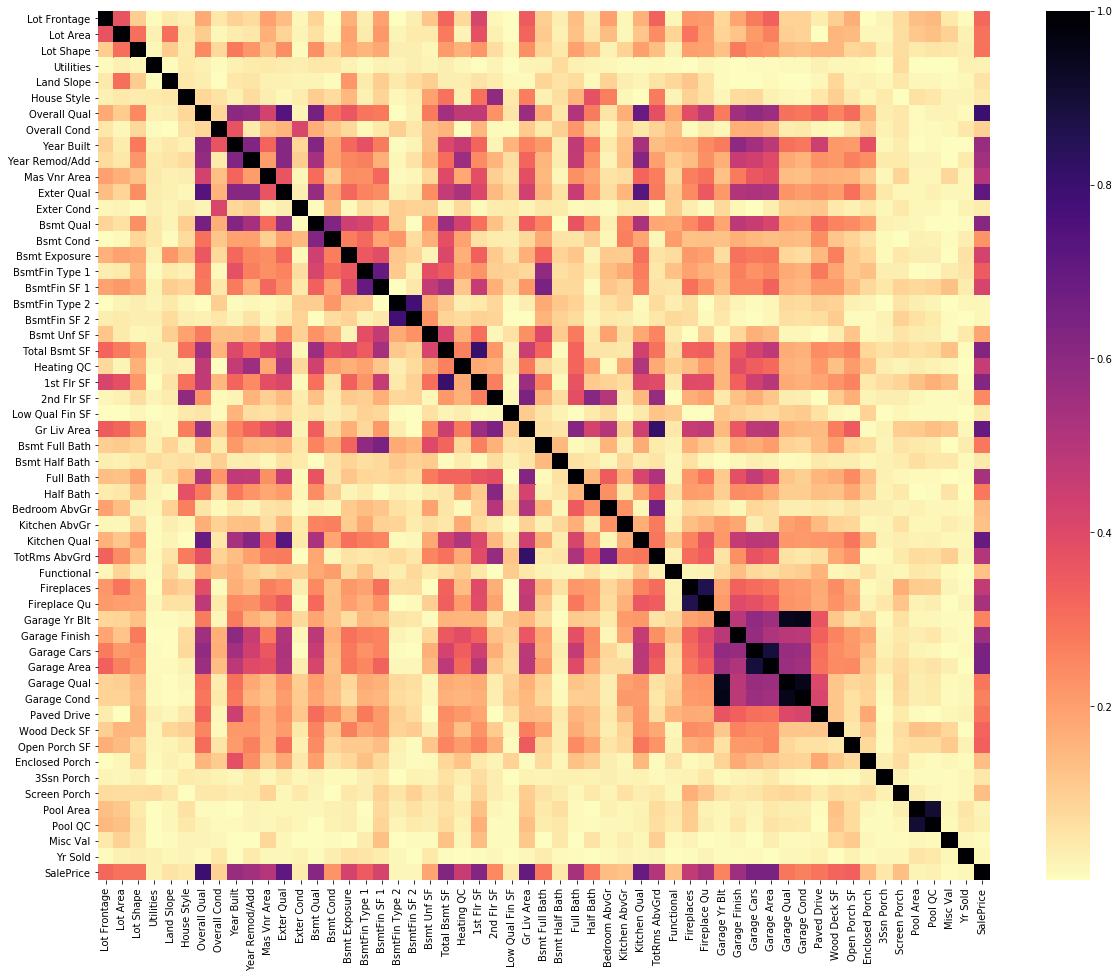

In [158]:
# start from strach, using knowledge gained from other model runs

# start by picking out numeric features that have high linear relationship with price, but not with each other

# look at correlation heatmap
housing8 = housing[num_col].copy()
housing8['SalePrice']=housing['SalePrice']
fig, ax = plt.subplots(figsize=(20,16))
sns.heatmap(abs(housing8.corr()), cmap='magma_r')

In [159]:
# get a list of features that have a correlation with price stronger than 40%
features_to_include = []
for col in housing8.columns:
    if housing8.corr()['SalePrice'][col]>0.4:
        features_to_include.append(col)

features_to_include

['Overall Qual',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'Exter Qual',
 'Bsmt Qual',
 'Bsmt Exposure',
 'BsmtFin SF 1',
 'Total Bsmt SF',
 'Heating QC',
 '1st Flr SF',
 'Gr Liv Area',
 'Full Bath',
 'Kitchen Qual',
 'TotRms AbvGrd',
 'Fireplaces',
 'Fireplace Qu',
 'Garage Finish',
 'Garage Cars',
 'Garage Area',
 'SalePrice']

In [160]:
# select these features only
housing8 = housing8[features_to_include]

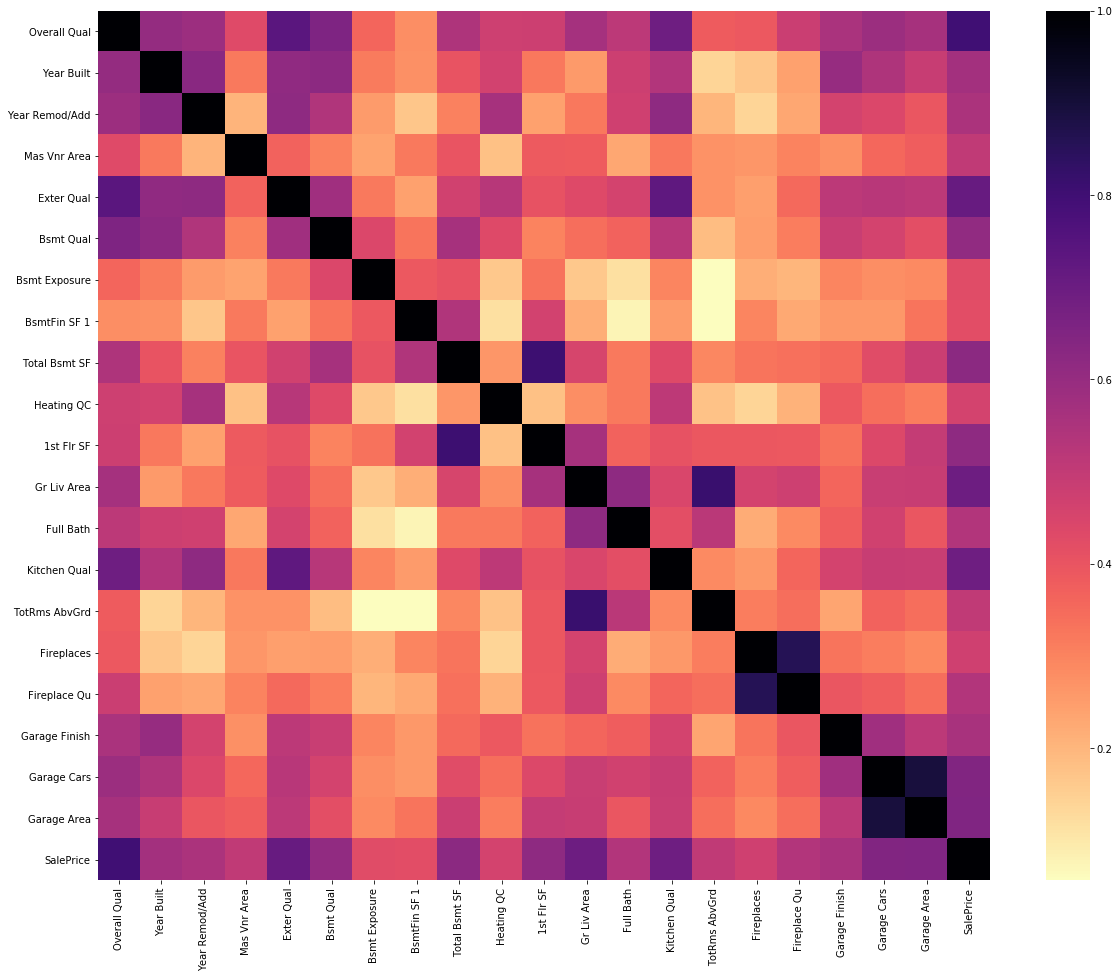

In [161]:
# look at co-linearity between these features
fig, ax = plt.subplots(figsize=(20,16))
sns.heatmap(abs(housing8.corr()), cmap='magma_r')

In [162]:
# get a list of feature pairs that have a strong linear relationship with each other
for combo in combinations(housing8.columns, 2):
    if abs(housing8.corr()[list(combo)[0]][list(combo)[1]])>0.70:
        print(list(combo))

['Overall Qual', 'Exter Qual']
['Overall Qual', 'SalePrice']
['Exter Qual', 'Kitchen Qual']
['Exter Qual', 'SalePrice']
['Total Bsmt SF', '1st Flr SF']
['Gr Liv Area', 'TotRms AbvGrd']
['Fireplaces', 'Fireplace Qu']
['Garage Cars', 'Garage Area']


In [163]:
# examine which features to remove by considering linear relationship to price for each feature in pair

print(housing8.corr()['SalePrice']['Total Bsmt SF'])
print(housing8.corr()['SalePrice']['1st Flr SF'])
print('')
print(housing8.corr()['SalePrice']['Gr Liv Area'])
print(housing8.corr()['SalePrice']['TotRms AbvGrd'])
print('')
print(housing8.corr()['SalePrice']['Fireplaces'])
print(housing8.corr()['SalePrice']['Fireplace Qu'])
print('')
print(housing8.corr()['SalePrice']['Garage Cars'])
print(housing8.corr()['SalePrice']['Garage Area'])

0.6257751372542204
0.6184861410533946

0.6970384443056628
0.5040143180735341

0.4710928937629878
0.538925051153872

0.6477813459587413
0.649896849661898


In [164]:
# remove feature in pair that has weakest linear relationship to price
remove_list = ['Exter Qual','1st Flr SF','TotRms AbvGrd','Fireplaces','Garage Cars'] 
housing8.drop(columns=remove_list, inplace=True)

#### Model 8.1 - Linear Regression

In [165]:
# set up features dataframe with features selected above
X8_1 = housing8.drop(columns=['SalePrice'])
y = housing8['SalePrice']

In [166]:
# look at cross validated scores from Linear Regression
print('mean',( -cross_val_score(LinearRegression(), X8_1, y, cv=10,scoring='neg_mean_squared_error').mean())**0.5)
print('max', (-cross_val_score(LinearRegression(), X8_1, y, cv=10, scoring='neg_mean_squared_error').min())**0.5)
print('min', (-cross_val_score(LinearRegression(), X8_1, y, cv=10, scoring='neg_mean_squared_error').max())**0.5)

mean 34040.01007183286
max 48029.610462491895
min 25315.890814418108


In [167]:
# fit model
lr_8_1 = LinearRegression()
lr_8_1.fit(X8_1, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [168]:
# make predictions
X8_1_fulltest = test[X8_1.columns].copy()
predict_fulltest = lr_8_1.predict(X8_1_fulltest)

# save model output
model8_1_predict = pd.DataFrame(predict_fulltest, columns=['SalePrice'])
model8_1_outcomes = pd.concat([test['Id'],model8_1_predict], axis=1)
model8_1_outcomes.set_index('Id', inplace=True)
model8_1_outcomes.to_csv('./Data/model8_1_submission.csv')

In [169]:
# score: 42333

#### Model 8.2 - Lasso

In [170]:
# use same features as before
X8_2 = X8_1.copy()

# scale
ss8_2 = StandardScaler()
X8_2_scaled = ss8_2.fit_transform(X8_2)

# find best alpha
lasso_model = LassoCV(n_alphas=500)
lasso_model = lasso_model.fit(X8_2_scaled, y)
lasso_model_optimal_alpha = lasso_model.alpha_
lasso_model_optimal_alpha

639.9574719900772

In [171]:
# find more specific alpha
l_alphas = np.linspace(600,680,200)
lasso_model = LassoCV(alphas=l_alphas)
lasso_model = lasso_model.fit(X8_2_scaled,y)
lasso_model_optimal_alpha = lasso_model.alpha_
lasso_model_optimal_alpha

634.9748743718593

In [172]:
# fit lasso model and look at cross validated scores
lasso_M8_2 = Lasso(alpha=lasso_model_optimal_alpha)

print('mean', (-cross_val_score(lasso_M8_2, X8_2_scaled, y, cv=10, scoring='neg_mean_squared_error').mean())**0.5)
print('max', (-cross_val_score(lasso_M8_2, X8_2_scaled, y, cv=10, scoring='neg_mean_squared_error').min())**0.5)
print('min', (-cross_val_score(lasso_M8_2, X8_2_scaled, y, cv=10, scoring='neg_mean_squared_error').max())**0.5)

# get number of non-zero coefficients
lasso_M8_2.fit(X8_2_scaled, y)
betas = pd.DataFrame(lasso_M8_2.coef_, index = X8_2.columns, columns=['beta'])
sum(betas['beta']!=0)

mean 33974.550718738166
max 47265.4742741935
min 25204.17034071327


15

In [173]:
# get predictions
X8_2_fulltest = test[X8_2.columns].copy()
X8_2_fulltest_scaled = ss8_2.transform(X8_2_fulltest)
predict_fulltest = lasso_M8_2.predict(X8_2_fulltest_scaled)

# save model output
model8_2_predict = pd.DataFrame(predict_fulltest, columns=['SalePrice'])
model8_2_outcomes = pd.concat([test['Id'],model8_2_predict], axis=1)
model8_2_outcomes.set_index('Id', inplace=True)
model8_2_outcomes.to_csv('./Data/model8_2_submission.csv')

In [174]:
# score: 42386
# notice score hasn't improved much and we're not removing any variables here - maybe ridge would be better

#### Model 8.3 - Ridge

In [175]:
# use same features and scaler as before
X8_3 = X8_2.copy()
X8_3_scaled = X8_2_scaled.copy()
ss8_3 = ss8_2

# find best alpha for ridge
r_alphas = np.logspace(0,5,100)
ridge_model = RidgeCV(alphas = r_alphas)
ridge_model = ridge_model.fit(X8_3_scaled,y)
ridge_model_optimal_alpha = ridge_model.alpha_
ridge_model_optimal_alpha

166.81005372000593

In [176]:
# find more accurate best alpha for ridge
r_alphas = np.logspace(0,3,200)
ridge_model = RidgeCV(alphas = r_alphas)
ridge_model = ridge_model.fit(X8_3_scaled,y)
ridge_model_optimal_alpha = ridge_model.alpha_
ridge_model_optimal_alpha

176.2914118095948

In [177]:
# fit ridge model and look at cross validated scores
ridge_M8_3 = Ridge(alpha=lasso_model_optimal_alpha)

print('mean', (-cross_val_score(ridge_M8_3, X8_3_scaled, y, cv=10, scoring='neg_mean_squared_error').mean())**0.5)
print('max', (-cross_val_score(ridge_M8_3, X8_3_scaled, y, cv=10, scoring='neg_mean_squared_error').min())**0.5)
print('min', (-cross_val_score(ridge_M8_3, X8_3_scaled, y, cv=10, scoring='neg_mean_squared_error').max())**0.5)

# get number of non-zero coefficients
ridge_M8_3.fit(X8_3_scaled, y)
betas = pd.DataFrame(ridge_M8_3.coef_, index = X8_3.columns, columns=['beta'])
sum(betas['beta']!=0)

mean 34287.65667284694
max 44158.28677997141
min 25666.629487937338


15

In [178]:
# get predictions
X8_3_fulltest = test[X8_3.columns].copy()
X8_3_fulltest_scaled = ss8_3.transform(X8_3_fulltest)
predict_fulltest = ridge_M8_3.predict(X8_3_fulltest_scaled)

# save model output
model8_3_predict = pd.DataFrame(predict_fulltest, columns=['SalePrice'])
model8_3_outcomes = pd.concat([test['Id'],model8_3_predict], axis=1)
model8_3_outcomes.set_index('Id', inplace=True)
model8_3_outcomes.to_csv('./Data/model8_3_submission.csv')

In [179]:
# score: 43331

#### Model 8.4 - Consider categorical columns

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


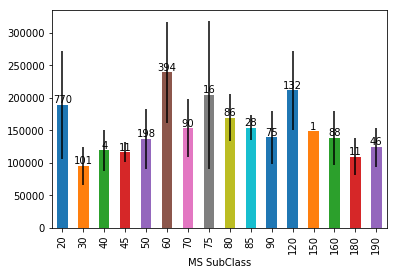

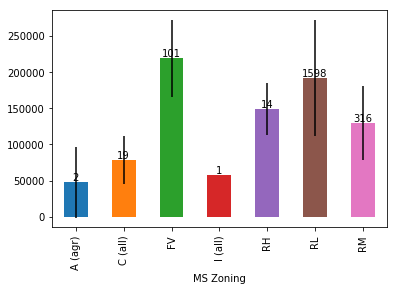

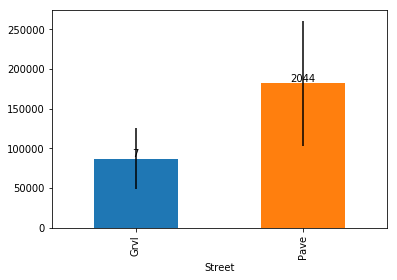

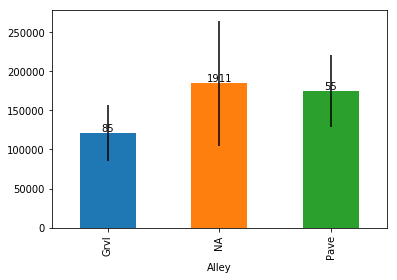

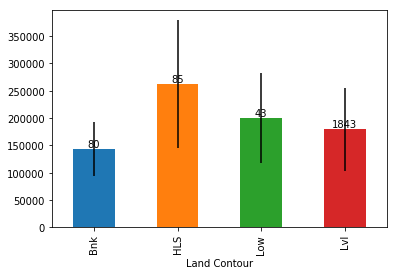

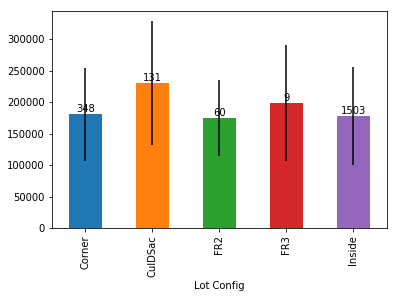

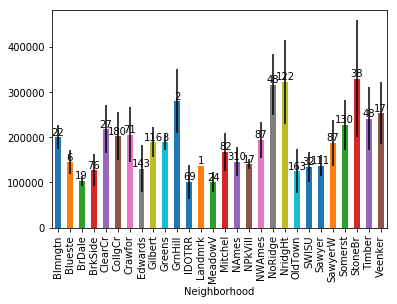

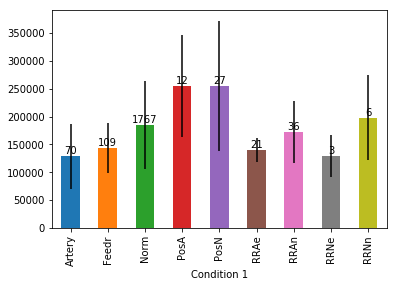

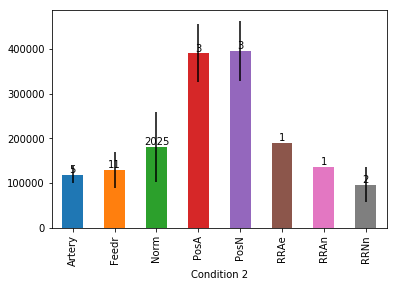

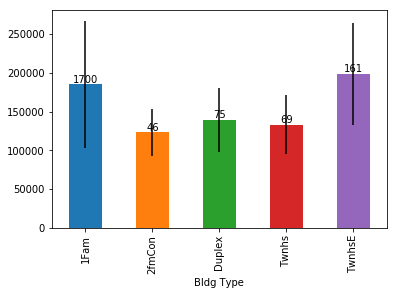

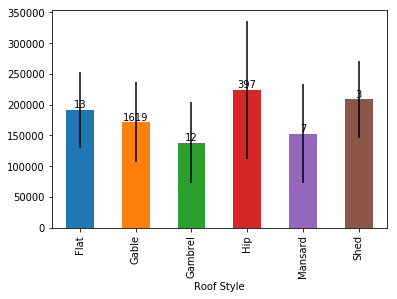

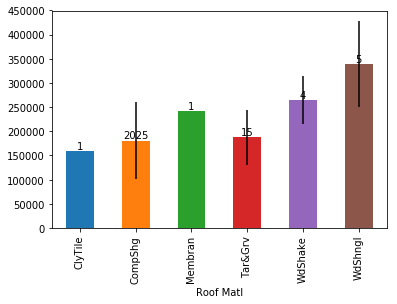

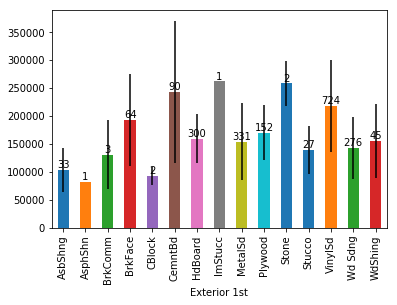

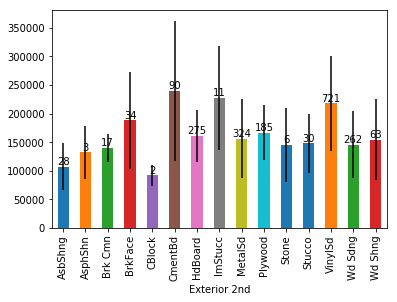

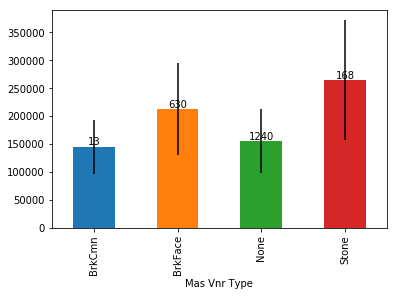

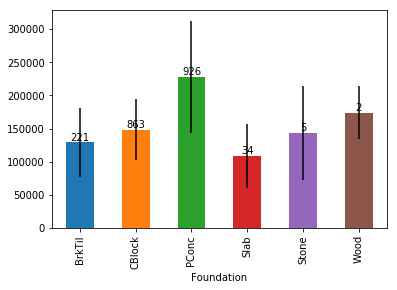

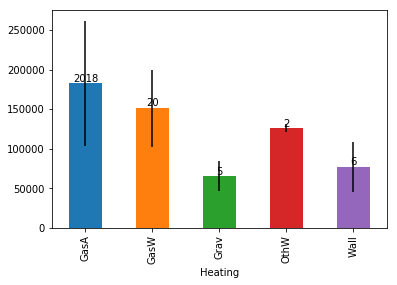

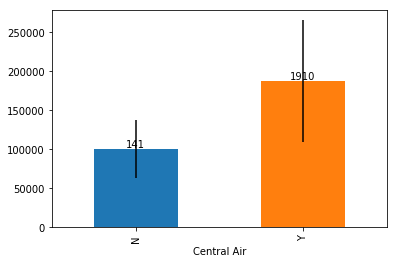

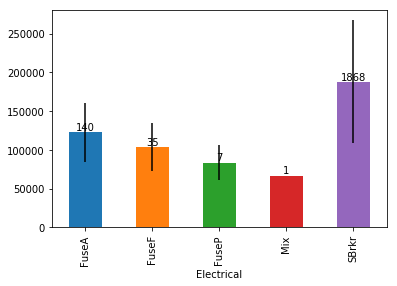

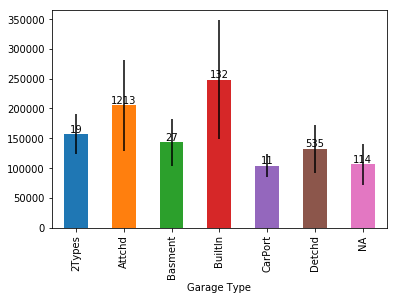

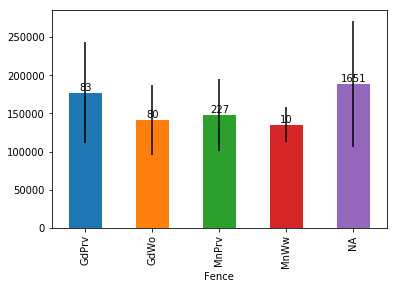

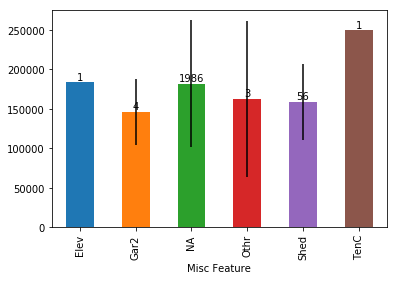

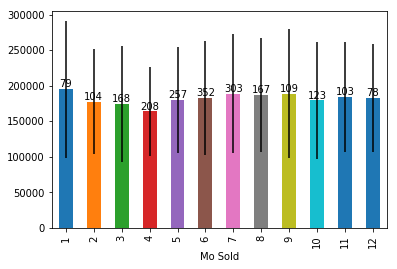

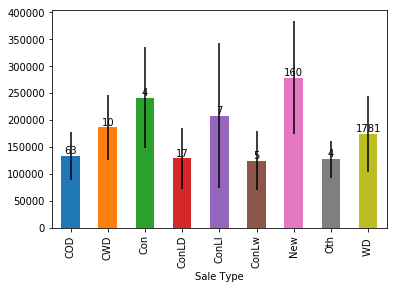

In [180]:
# use features from previous model
X8_4 = X8_3.copy()

# plot means of sale price grouped by category, for all categorical features

for variable in cat_cols: 
    fig, ax = plt.subplots()
    ax = plt.gca()
    
    # plot mean price with error bars, grouped by category
    means = housing.groupby(variable)['SalePrice'].mean()
    errors = housing.groupby(variable)['SalePrice'].std()
    means.plot.bar(yerr=errors)
    
    # make some labels for number of observations
    rects = ax.patches
    labels = list(housing.groupby(variable)['SalePrice'].count())

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
    
    ax.set_title('')
    

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


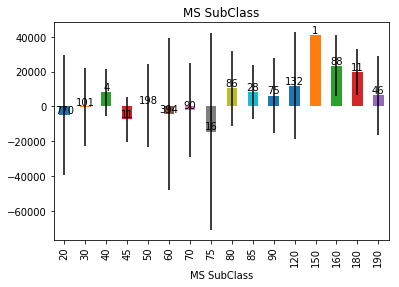

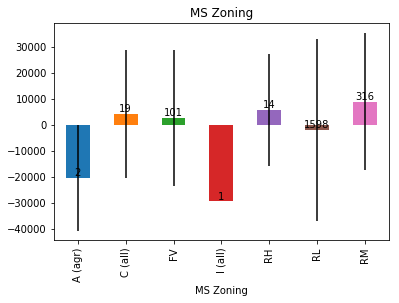

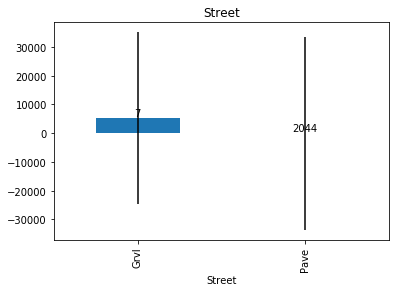

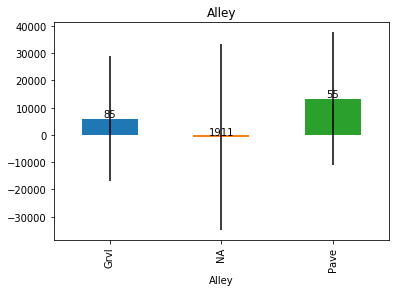

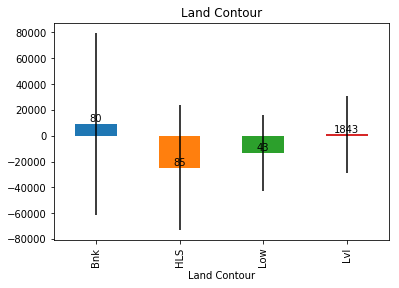

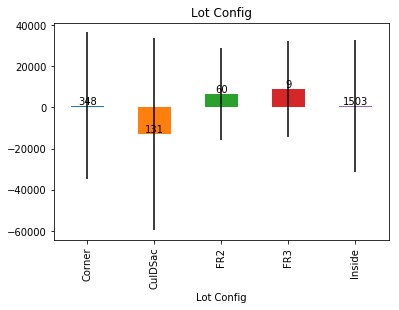

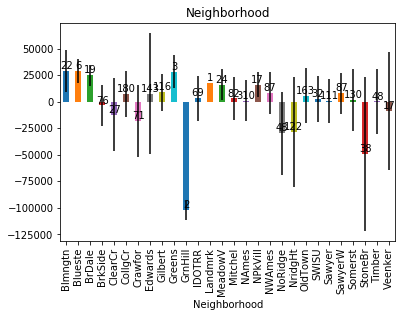

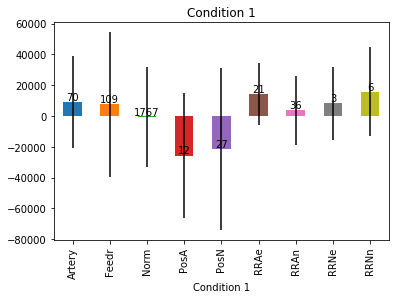

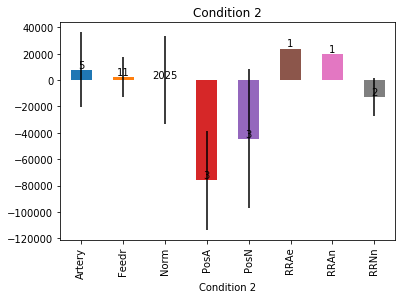

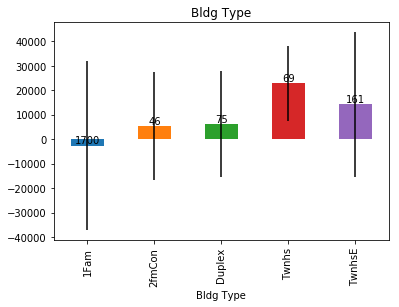

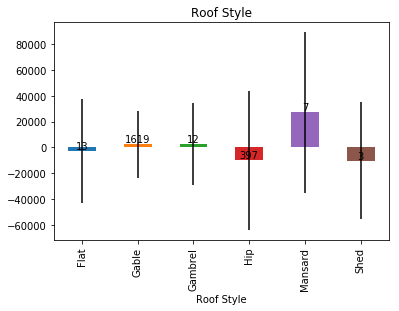

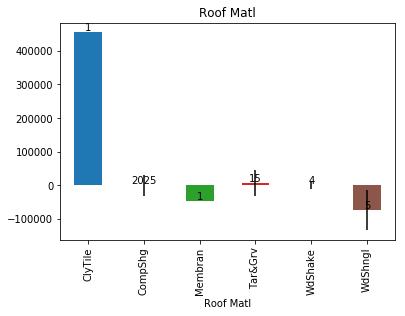

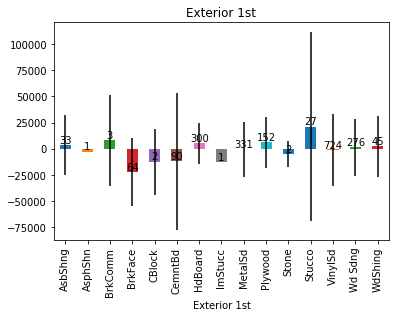

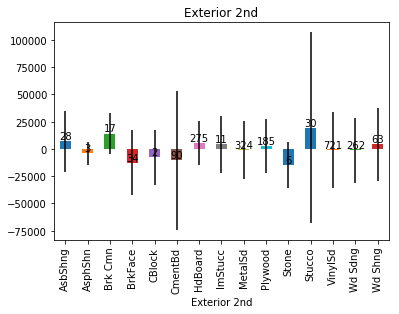

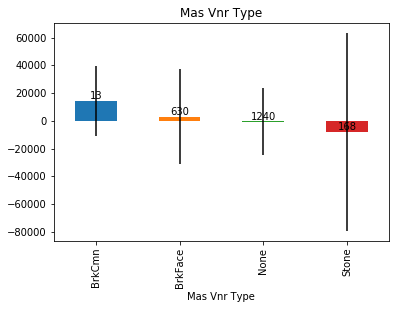

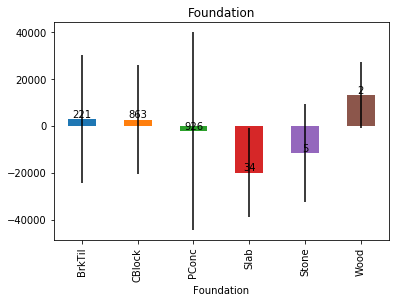

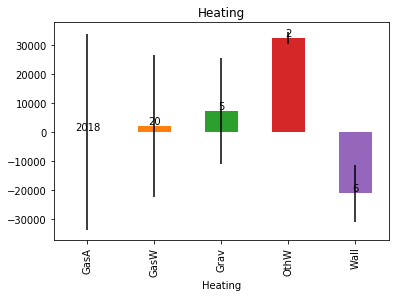

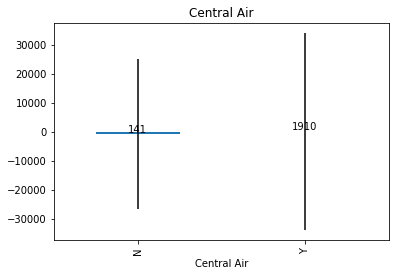

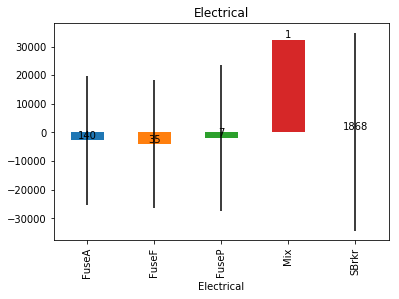

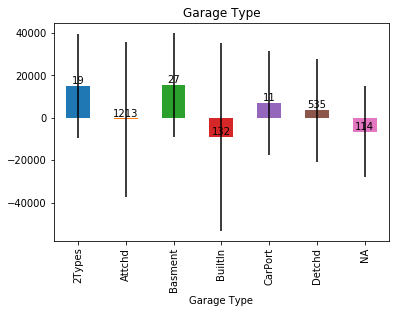

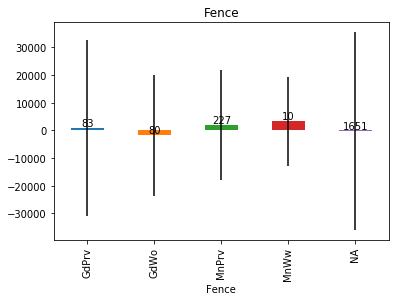

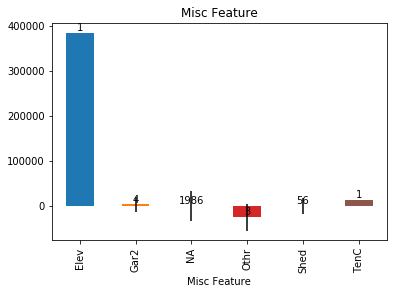

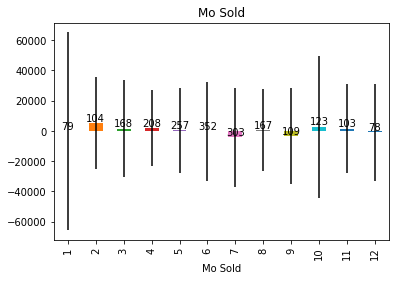

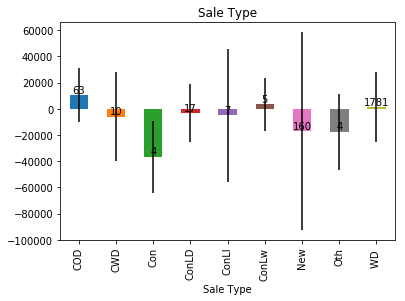

In [181]:
# check what we're mispricing in our model

housing_M8_3_predict = housing.copy()
housing_M8_3_predict['M8_3_predict'] = ridge_M8_3.predict(X8_3_scaled)
housing_M8_3_predict['Residuals'] = (housing_M8_3_predict['M8_3_predict']-housing_M8_3_predict['SalePrice'])

# plot mean residual by category, with errors, for each categorical column
for variable in cat_cols: 
    fig, ax = plt.subplots()
    ax = plt.gca()
    
    # plot mean residual with error bars, grouped by category
    means = housing_M8_3_predict.groupby(variable)['Residuals'].mean()
    errors = housing_M8_3_predict.groupby(variable)['Residuals'].std()
    means.plot.bar(yerr=errors)
    ax.set_title(variable)
    
    # make some labels for number of observations
    rects = ax.patches
    labels = list(housing.groupby(variable)['SalePrice'].count())

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
    
    

In [182]:
# some elements we're mispricing are:
#    Industrial and agricultural land - 1 obs and 2 obs
#    Grn Hill area - 2 obs
#    PosA condition 2 - 3 obs
#    Clay Tile roof - 1 obs
#    OthW heating - 2 obs
#    Mix electrical - 1 obs
#    Elevator - 1 obs

# generally low observations to base model coefficients on but...
#    MS Zoning categories do seem to have different price ranges associated with them AND this makes sense intuitively
#    Different neighborhoods do seem to have different price ranges associated with them AND this makes sense intuitively
#    Proximity to positive off-sit features does seem to be associated with higher price AND this makes sense intuitively

# The other features don't seem to have different prices associated with different categories 
# Misc features should already be captured in Misc Value, which doesn't actually correlate well with SalePrice

In [183]:
# add dummies for zone, neighborhoods and flag for proximity for positive off site features
# add dummies as flags so it will work for test data, even if categories list is different

flag_func = (lambda x: 1 if (x['Condition 1']=='PosA') or (x['Condition 1']=='PosB') or (x['Condition 2']=='PosA') or (x['Condition 2']=='PosB') else 0)
def add_flags_model8(features_df, full_df):
    
    # add flags for MS Zone
    for zone in housing['MS Zoning'].unique():
        features_df[zone] = full_df['MS Zoning'].map(lambda x: 1 if x==zone else 0)
    
    # add flags for Neighborhood
    for neighborhood in housing['Neighborhood'].unique():
        features_df[neighborhood] = full_df['Neighborhood'].map(lambda x: 1 if x==neighborhood else 0)
    
    # add flag for proximity to positive off-site feature
    features_df['Off-site flag'] = full_df.apply(flag_func, axis=1)

add_flags_model8(X8_4, housing)

In [184]:
# now have lots of columns, so use lasso to reduce overfitting

# scale model before using lasso
ss8_4 = StandardScaler()
X8_4_scaled = ss8_4.fit_transform(X8_4)

# find best alpha for lasso
lasso_model = LassoCV(n_alphas = 500)
lasso_model = lasso_model.fit(X8_4_scaled, y)
lasso_optimal_alpha = lasso_model.alpha_
lasso_optimal_alpha

271.2724084160254

In [185]:
# find more accurate alpha
l_alphas = np.linspace(250,300,200)
lasso_model = LassoCV(alphas=l_alphas)
lasso_model = lasso_model.fit(X8_4_scaled, y)
lasso_optimal_alpha = lasso_model.alpha_
lasso_optimal_alpha

272.61306532663315

In [186]:
# fit lasso model and look at cross validated scores
lasso_M8_4 = Lasso(alpha=lasso_model_optimal_alpha)

print('mean', (-cross_val_score(lasso_M8_4, X8_4_scaled, y, cv=10, scoring='neg_mean_squared_error').mean())**0.5)
print('max', (-cross_val_score(lasso_M8_4, X8_4_scaled, y, cv=10, scoring='neg_mean_squared_error').min())**0.5)
print('min', (-cross_val_score(lasso_M8_4, X8_4_scaled, y, cv=10, scoring='neg_mean_squared_error').max())**0.5)

# find number of non-zero coefficients
lasso_M8_4.fit(X8_4_scaled, y)
betas = pd.DataFrame(lasso_M8_4.coef_, index = X8_4.columns, columns=['beta'])
sum(betas['beta']!=0)

mean 31682.87296160872
max 42949.518045934354
min 24166.0273162504


38

In [187]:
# start with columns from X8_3 and add flags
X8_4_fulltest = test[X8_3.columns].copy()
add_flags_model8(X8_4_fulltest, test)

# fit and save model
X8_4_fulltest_scaled = ss8_4.transform(X8_4_fulltest)
predict_fulltest = lasso_M8_4.predict(X8_4_fulltest_scaled)
model8_4_predict = pd.DataFrame(predict_fulltest, columns=['SalePrice'])
model8_4_outcomes = pd.concat([test['Id'],model8_4_predict], axis=1)
model8_4_outcomes.set_index('Id', inplace=True)
model8_4_outcomes.to_csv('./Data/model8_4_submission.csv')

In [188]:
# score: 39419

#### Model 8.5 - add important interaction terms from before

In [189]:
X8_5 = X8_4.copy()
X8_5['Exter Qual + Gr Liv Area'] = housing['Exter Qual']*housing['Gr Liv Area']
X8_5['Bsmt Qual + Gr Liv Area'] = housing['Bsmt Qual']*housing['Gr Liv Area']
X8_5['Kitchen Qual + Gr Liv Area'] = housing['Kitchen Qual']*housing['Gr Liv Area']

In [190]:
# scale before using lasso
ss8_5 = StandardScaler()
X8_5_scaled = ss8_5.fit_transform(X8_5)

# find best alpha
lasso_model = LassoCV(n_alphas = 500)
lasso_model = lasso_model.fit(X8_5_scaled, y)
lasso_optimal_alpha = lasso_model.alpha_
lasso_optimal_alpha

293.0684425972263

In [191]:
# find more accurate best alpha
l_alphas = np.linspace(275,325,200)
lasso_model = LassoCV(alphas=l_alphas)
lasso_model = lasso_model.fit(X8_5_scaled, y)
lasso_optimal_alpha = lasso_model.alpha_
lasso_optimal_alpha

292.8391959798995

In [192]:
# fit lasso model and look at cross validated scores
lasso_M8_5 = Lasso(alpha=lasso_model_optimal_alpha)

print('mean', (-cross_val_score(lasso_M8_5, X8_5_scaled, y, cv=10, scoring='neg_mean_squared_error').mean())**0.5)
print('max', (-cross_val_score(lasso_M8_5, X8_5_scaled, y, cv=10, scoring='neg_mean_squared_error').min())**0.5)
print('min', (-cross_val_score(lasso_M8_5, X8_5_scaled, y, cv=10, scoring='neg_mean_squared_error').max())**0.5)

# get number of non-zero coefficients
lasso_M8_5.fit(X8_5_scaled, y)
betas = pd.DataFrame(lasso_M8_5.coef_, index = X8_5.columns, columns=['beta'])
sum(betas['beta']!=0)

mean 31602.325827424374
max 46880.10292950929
min 23093.375630095274


40

In [193]:
# start with columns from X8_3
X8_5_fulltest = test[X8_3.columns].copy()
# add select flags
add_flags_model8(X8_5_fulltest, test)
# add important interaction terms
X8_5_fulltest['Exter Qual + Gr Liv Area'] = test['Exter Qual']*test['Gr Liv Area']
X8_5_fulltest['Bsmt Qual + Gr Liv Area'] = test['Bsmt Qual']*test['Gr Liv Area']
X8_5_fulltest['Kitchen Qual + Gr Liv Area'] = test['Kitchen Qual']*test['Gr Liv Area']

# fit and save model
X8_5_fulltest_scaled = ss8_5.transform(X8_5_fulltest)
predict_fulltest = lasso_M8_5.predict(X8_5_fulltest_scaled)
model8_5_predict = pd.DataFrame(predict_fulltest, columns=['SalePrice'])
model8_5_outcomes = pd.concat([test['Id'],model8_5_predict], axis=1)
model8_5_outcomes.set_index('Id', inplace=True)
model8_5_outcomes.to_csv('./Data/model8_5_submission.csv')

In [194]:
# score: 39318